# Federated Learning Multi Teachers Knowledge Distillation (FL-MTKD)

Federated Learning Multi Teachers Knowledge Distillation (FL-MTKD) is a technique that enhances federated learning by incorporating knowledge from multiple teacher models. In this approach, decentralized devices train local models while keeping data private. These models, called teacher models, each learn from different datasets:. The student model then distills knowledge from these multiple teachers, leading to better generalization and more efficient learning. FL-MTKD combines the benefits of improved model performance and enhanced data privacy.

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-06-07 11:59:17.379813: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 11:59:17.411057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 11:59:17.411085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 11:59:17.411107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 11:59:17.417230: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
import pandas as pd
import random
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')
from sklearn import preprocessing

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from tqdm.notebook import tqdm
import time

#import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
import time
import numpy as np
IMAGE_SIZE = 200

### Importing Libraries for Deep-COVID and its hyperparameters

In [ ]:
'''
##### Training Teacher Model (Deep-COVID)
M. Ghaderzadeh, F. Asadi, R. Jafari, D. Bashash, H. Abolghasemi, and M. Aria. Deep
convolutional neural network–based computer-aided detection system for covid-19 using mul-
tiple lung scans: Design and implementation study. J Med Internet Res, 23:e27468, 2021,4.
http://www.ncbi.nlm.nih.gov/pubmed/33848973
'''

SEED = 7
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

from tensorflow.keras.applications import NASNetLarge
NETWORK = NASNetLarge

#from kaggle_datasets import KaggleDatasets

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report


import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print("Tensorflow version ", tf.__version__)

from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

image_size = 200
img_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="Augmentation",
)
#img_augmentation.layers[0].adapt(train_features_dataset2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

# dataset_id1 = 'covid19-lung-ct-scans'
# #GCS_PATH1 = KaggleDatasets().get_gcs_path(dataset_id1)
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

CLASSES = ['COVID-19', 'Non-COVID-19']
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE_ = [IMAGE_SIZE, IMAGE_SIZE]#224, 224
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)#224, 224, 3
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

METRICS = ['accuracy']

Epochs = 50
Early_Stop = 15
OPTIMIZER = tensorflow.keras.optimizers.legacy.Adam(lr = 1e-2, decay = 1e-4)

Fine_Tune_Epochs = 100
Fine_Tune_Early_Stop = 20
Fine_Tune_OPTIMIZER = tensorflow.keras.optimizers.legacy.Adam(lr = 1e-3, decay = 1e-6)
Fine_Tune_filepath = "Best-Model-FT.h5"

Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

FT_Callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min', min_delta=0.0001, cooldown=1, min_lr=1e-6),
    ModelCheckpoint(Fine_Tune_filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor='val_loss', patience=Fine_Tune_Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

from tensorflow.keras.layers import Lambda
input_tensor = Input(shape=input_shape)
input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)



Number of replicas: 1
Tensorflow version  2.14.0


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Functions to Evaluate Models after Training

In [ ]:
import seaborn as sns
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'

def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()

    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__,
                    predicted_labels=predictions)

## Data Source

Hopital 1 (Datasets 1), Hospital 2 (Dataset2 2) and Hospital 3 (Datasets 3)

- https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images (dataset3)
- https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/ (dataset3)

- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Dataset1)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Dataset1)

####  Loading NumPy Array Datasets:

In [ ]:
# # # Load the array from the file
input_data_x_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_input.npy')
output_label_y_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_output.npy')
input_data_x_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_input.npy')
output_label_y_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_output.npy')
input_data_x_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_input.npy')#.astype('float64')
output_label_y_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_output.npy')
#input_data_x_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_input.npy')
#output_label_y_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_output.npy')

#Now loaded_arr contains the array loaded from the file
print('------------------ DATASET 1 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_load.shape))

print('------------------ DATASET 2 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_2_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_2_load.shape))

print('------------------ DATASET 3 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_3_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_3_load.shape))

# print('------------------ DATASET 4 ---------------------')
# print('Input_x Data Shape: \n{0}'.format(input_data_x_4_load.shape))
# print('Output_y Data Shape: \n{0}'.format(output_label_y_4_load.shape))

------------------ DATASET 1 ---------------------
Input_x Data Shape: 
(4649, 200, 200, 1)
Output_y Data Shape: 
(4649, 2)
------------------ DATASET 2 ---------------------
Input_x Data Shape: 
(14486, 200, 200, 1)
Output_y Data Shape: 
(14486, 2)
------------------ DATASET 3 ---------------------
Input_x Data Shape: 
(2540, 200, 200, 1)
Output_y Data Shape: 
(2540, 2)


##### Data used to train teacher models (CovidCNN, DeepCovid and CovidVGG16) for each client (Hospitals)

In [ ]:
from sklearn.model_selection import train_test_split


train_features_dataset1, test_features_dataset1, train_labels_dataset1, test_labels_dataset1 = train_test_split(
    input_data_x_load[0:2500,:], output_label_y_load[0:2500,:], test_size=.20, random_state=25)

train_features_dataset2, test_features_dataset2, train_labels_dataset2, test_labels_dataset2 = train_test_split(
    input_data_x_2_load[0:6500,:], output_label_y_2_load[0:6500,:], test_size=.20, random_state=25)

train_features_dataset3, test_features_dataset3, train_labels_dataset3, test_labels_dataset3 = train_test_split(
    input_data_x_3_load[0:1200,:], output_label_y_3_load[0:1200,:], test_size=.20, random_state=25)

print('------ Training Teacher Models----------')
print('client 1 teacher dataset: ',train_features_dataset1.shape, test_features_dataset1.shape, train_labels_dataset1.shape, test_labels_dataset1.shape)
print('client 2 teacher dataset: ',train_features_dataset2.shape, test_features_dataset2.shape, train_labels_dataset2.shape, test_labels_dataset2.shape)
print('client 3 teacher dataset: ',train_features_dataset3.shape, test_features_dataset3.shape, train_labels_dataset3.shape, test_labels_dataset3.shape)

------ Training Teacher Models----------
client 1 teacher dataset:  (2000, 200, 200, 1) (500, 200, 200, 1) (2000, 2) (500, 2)
client 2 teacher dataset:  (5200, 200, 200, 1) (1300, 200, 200, 1) (5200, 2) (1300, 2)
client 3 teacher dataset:  (960, 200, 200, 1) (240, 200, 200, 1) (960, 2) (240, 2)


## Federated Learning Datasets

In [ ]:
def dataset_pixel_stat(dataset):
    mean_pixel_value = np.mean(dataset)
    variance_pixel_value = np.var(dataset)
    std_dev_pixel_value = np.std(dataset)
    # Display the computed statistics
    print("Mean Pixel Value:", mean_pixel_value)
    print("Variance of Pixel Values:", variance_pixel_value)
    print("Standard Deviation of Pixel Values:", std_dev_pixel_value)

    # Compute histograms of pixel values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Values (Entire Dataset)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Assuming you have subsets 'subset1' and 'subset2' of the dataset
    # Compute histograms for each subset
    plt.subplot(1, 2, 2)
    plt.hist(dataset[0:500,:].flatten(), bins=50, color='red', alpha=0.7, label='Subset 1')
    plt.hist(dataset[501:1000,:].flatten(), bins=50, color='green', alpha=0.7, label='Subset 2')
    plt.hist(dataset[1001:1500,:].flatten(), bins=50, color='yellow', alpha=0.7, label='Subset 3')

    plt.title('Histogram of Pixel Values (Subsets)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

In [ ]:
print('------ Federated Training----------')
train_features_dataset1_fed, test_features_dataset1_fed, train_labels_dataset1_fed, test_labels_dataset1_fed = train_test_split(
    input_data_x_load[2501:3901,:], output_label_y_load[2501:3901,:], test_size=.20, random_state=25)
train_features_dataset2_fed, test_features_dataset2_fed, train_labels_dataset2_fed, test_labels_dataset2_fed = train_test_split(
    input_data_x_2_load[6501:10400,:], output_label_y_2_load[6501:10400,:], test_size=.20, random_state=25)
train_features_dataset3_fed, test_features_dataset3_fed, train_labels_dataset3_fed, test_labels_dataset3_fed = train_test_split(
    input_data_x_3_load[1201:,:], output_label_y_3_load[1201:,:], test_size=.20, random_state=25)
print('client 1 federated dataset: ', train_features_dataset1_fed.shape, test_features_dataset1_fed.shape, train_labels_dataset1_fed.shape, test_labels_dataset1_fed.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed.shape, test_features_dataset2_fed.shape, train_labels_dataset2_fed.shape, test_labels_dataset2_fed.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed.shape, test_features_dataset3_fed.shape, train_labels_dataset3_fed.shape, test_labels_dataset3_fed.shape)


------ Federated Training----------
client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


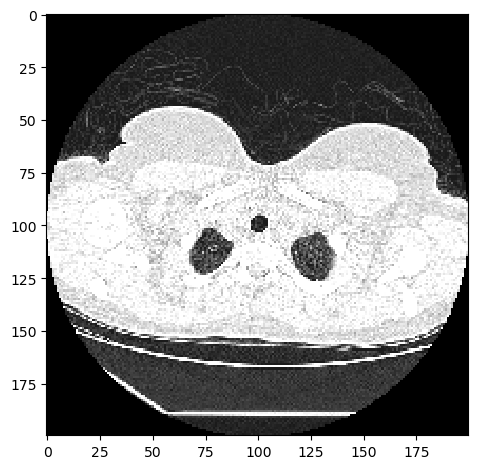

---------------Client 2 sample Image -----------------


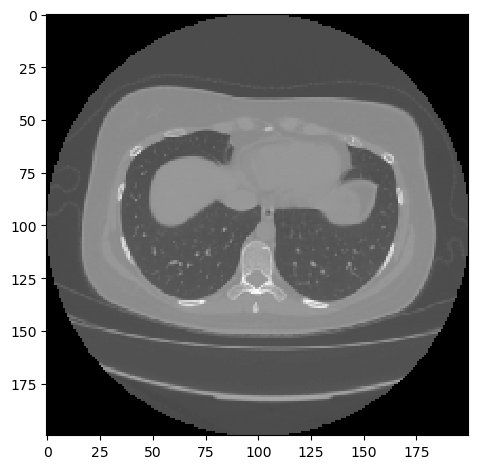

---------------Client 3 sample Image -----------------


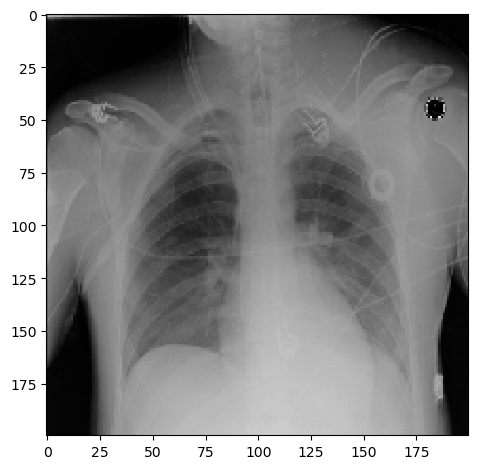

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed[0])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed[100])
show()

In [ ]:
print('--------------------- Testing dataset--------------')
# Assuming client_images and client_labels are numpy arrays or lists of numpy arrays
X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
                                  test_features_dataset3_fed), axis=0)
y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
                                  test_labels_dataset3_fed), axis=0)

--------------------- Testing dataset--------------


### Preparing The Federated Dataset (non_iid Dataset )

Mean Pixel Value: 0.5149437324054628
Variance of Pixel Values: 0.13384306055452233
Standard Deviation of Pixel Values: 0.36584567860577816


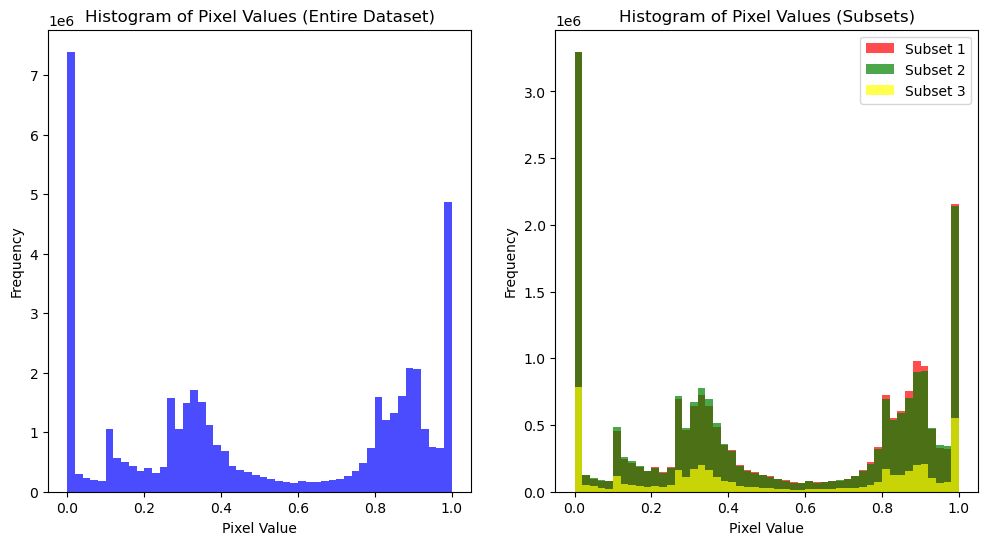

Mean Pixel Value: 0.2761424951121855
Variance of Pixel Values: 0.056925370933381306
Standard Deviation of Pixel Values: 0.23859038315359926


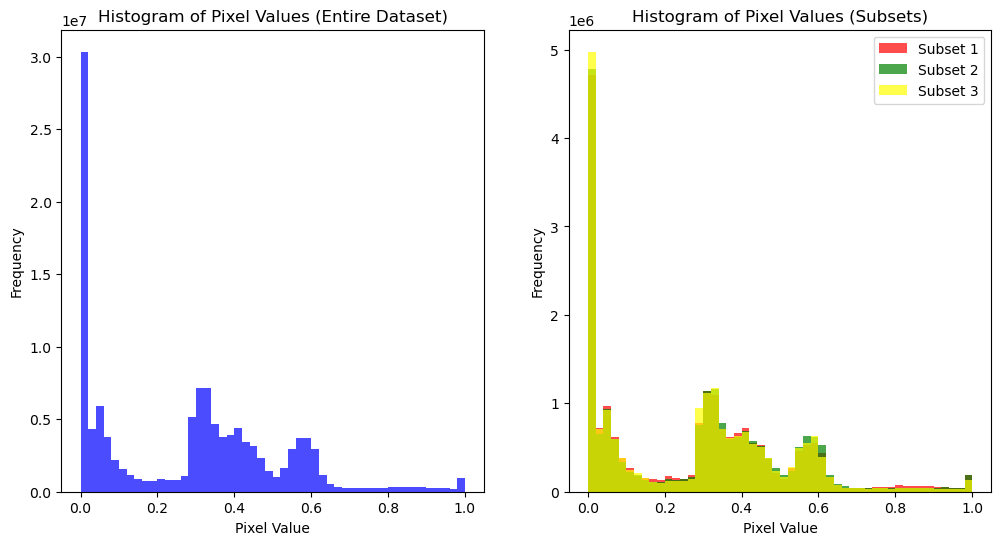

Mean Pixel Value: 0.5393774509803901
Variance of Pixel Values: 0.07674632723644069
Standard Deviation of Pixel Values: 0.2770312748345224


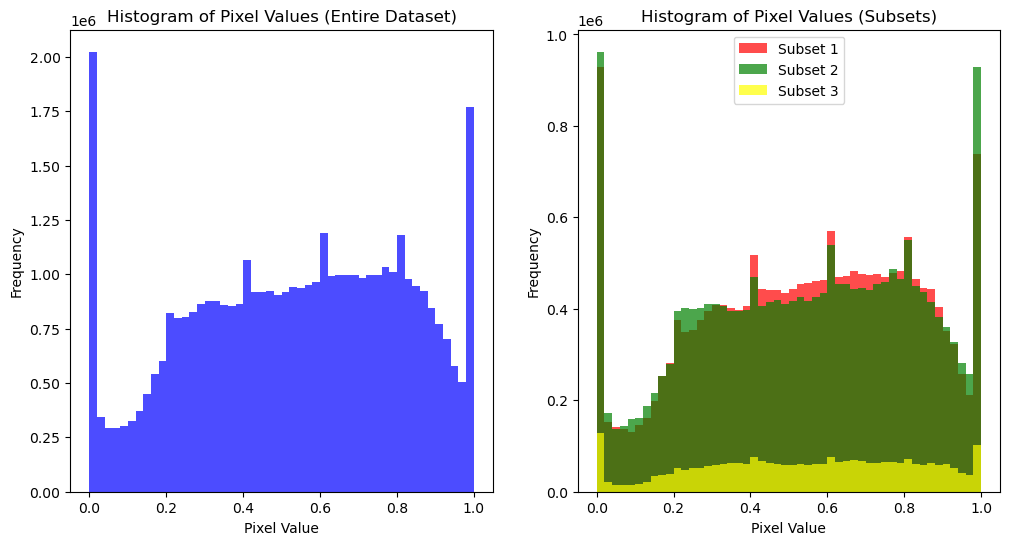

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed)
dataset_pixel_stat(train_features_dataset2_fed)
dataset_pixel_stat(train_features_dataset3_fed)

###### non-iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed, train_labels_dataset2_fed),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]#(train_features_dataset3_fed, train_labels_dataset3_fed)

NUM_CLIENTS = len(client_data)  # Number of clients
BATCH_SIZE = 20

def create_tf_dataset_for_client(client_dataset):
    """Create a tf.data.Dataset object for a client's data."""
    client_images, client_labels = client_dataset
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    return dataset

client_datasets = [create_tf_dataset_for_client(data) for data in client_data]

def preprocess_dataset(dataset, batch_size=BATCH_SIZE , shuffle_buffer_size=10000000):
    """Preprocess the dataset."""
    return dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#federated_clients
fed_clients = ['client_'+str(i) for i in range(1,NUM_CLIENTS+1)]

# Federated data preparation
federated_train_data_nonIID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid Unbalanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid Unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### non-iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed[0:1200,:], train_labels_dataset2_fed[0:1200,:]),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_nonIID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid balanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Preparing The Federated Dataset (iid Dataset )

In [ ]:
train_features_dataset1_fed_iid, test_features_dataset1_fed_iid, train_labels_dataset1_fed_iid, test_labels_dataset1_fed_iid = train_test_split(
    input_data_x_2_load[6501:7901,:], output_label_y_2_load[6501:7901,:], test_size=.20, random_state=420)
train_features_dataset2_fed_iid, test_features_dataset2_fed_iid, train_labels_dataset2_fed_iid, test_labels_dataset2_fed_iid = train_test_split(
    input_data_x_2_load[7901:11800,:], output_label_y_2_load[7901:11800,:], test_size=.20, random_state=42000)
train_features_dataset3_fed_iid, test_features_dataset3_fed_iid, train_labels_dataset3_fed_iid, test_labels_dataset3_fed_iid = train_test_split(
    input_data_x_2_load[11800:13139,:], output_label_y_2_load[11800:13139,:], test_size=.20, random_state=402)
print('client 1 federated dataset: ', train_features_dataset1_fed_iid.shape, test_features_dataset1_fed_iid.shape, train_labels_dataset1_fed_iid.shape, test_labels_dataset1_fed_iid.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed_iid.shape, test_features_dataset2_fed_iid.shape, train_labels_dataset2_fed_iid.shape, test_labels_dataset2_fed_iid.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed_iid.shape, test_features_dataset3_fed_iid.shape, train_labels_dataset3_fed_iid.shape, test_labels_dataset3_fed_iid.shape)

client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


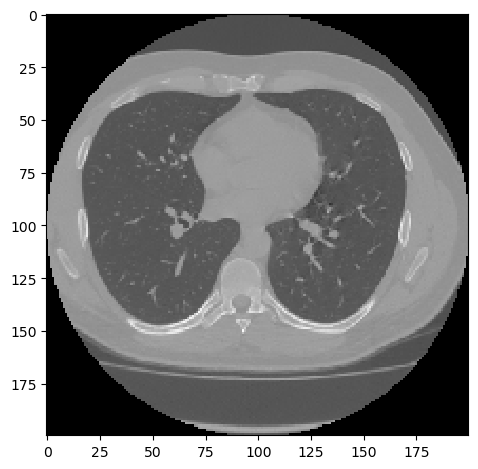

---------------Client 2 sample Image -----------------


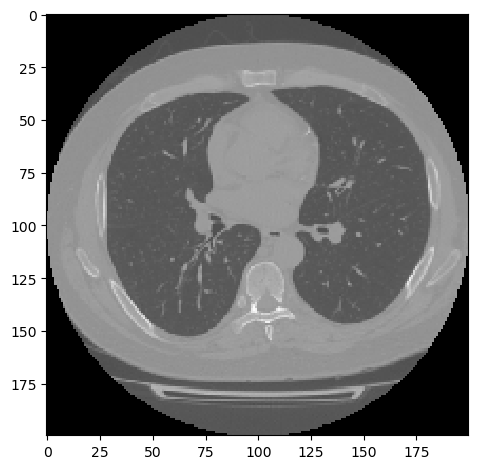

---------------Client 3 sample Image -----------------


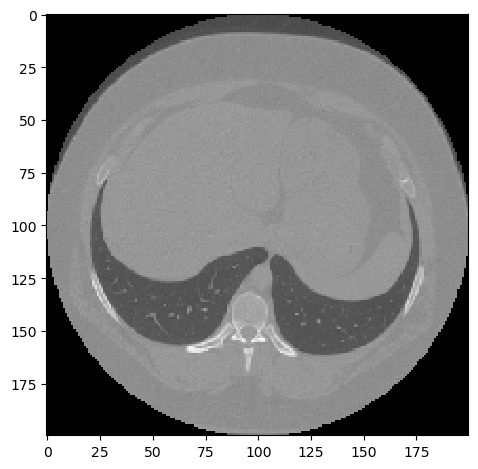

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed_iid[100])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed_iid[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed_iid[0])
show()

Mean Pixel Value: 0.27608563541666487
Variance of Pixel Values: 0.05798798046170928
Standard Deviation of Pixel Values: 0.24080693607475115


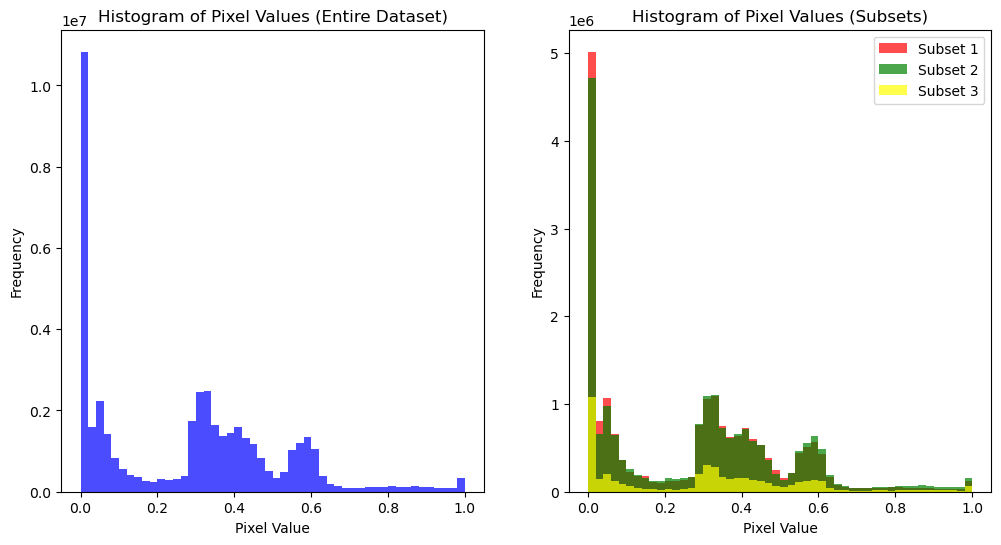

Mean Pixel Value: 0.27634676021097637
Variance of Pixel Values: 0.05656223598683317
Standard Deviation of Pixel Values: 0.2378281648308988


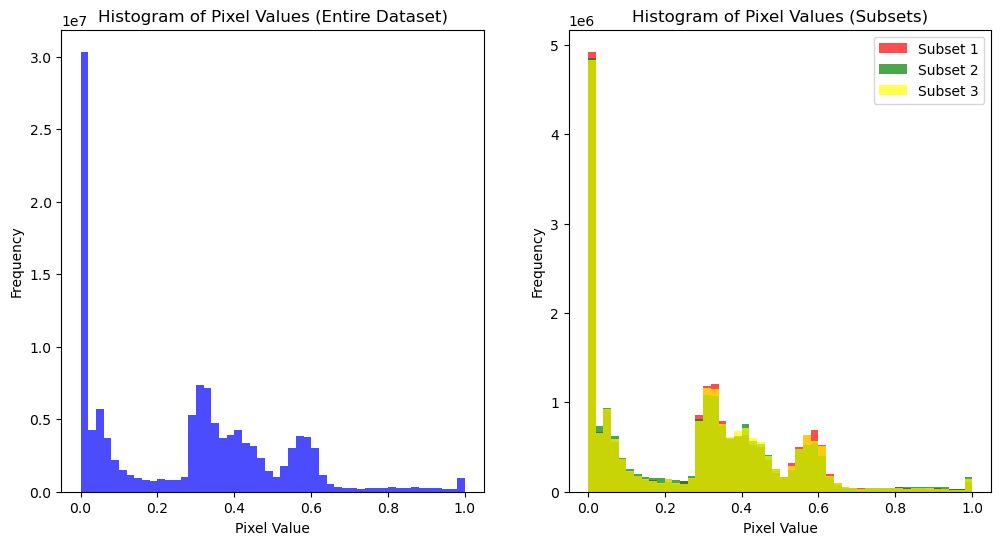

Mean Pixel Value: 0.2750474700206881
Variance of Pixel Values: 0.056656517144616544
Standard Deviation of Pixel Values: 0.23802629506971817


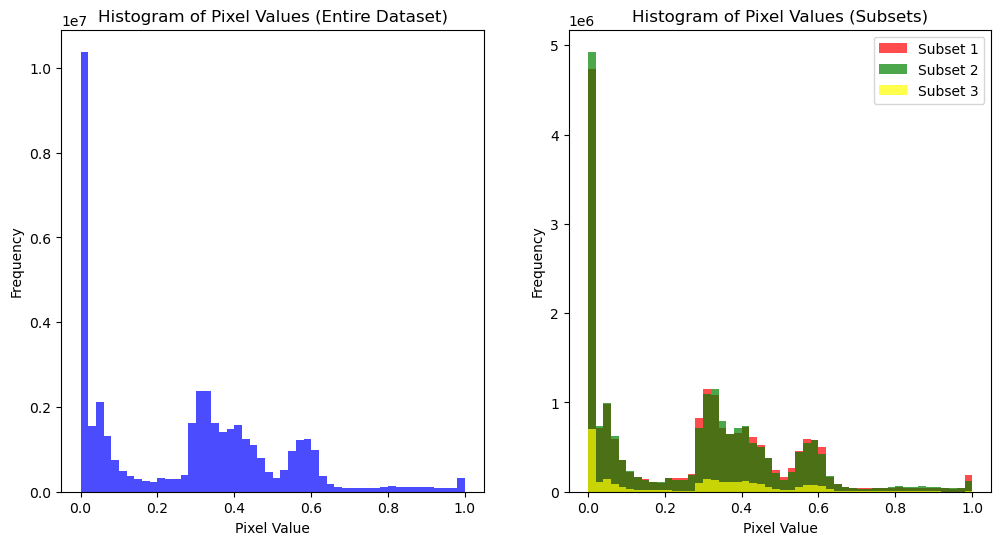

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed_iid)
dataset_pixel_stat(train_features_dataset2_fed_iid)
dataset_pixel_stat(train_features_dataset3_fed_iid)

###### iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid, train_labels_dataset2_fed_iid),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid unbalanced Dataset Data type: ', type(federated_train_data_IID_unbalanced))
print('Length: ', len(federated_train_data_IID_unbalanced))

Fedrated iid unbalanced Dataset Data type:  <class 'list'>
Length:  3


In [ ]:
# def convert_types(image, label):
#     image = tf.cast(image, tf.float64)  # Convert image from uint8 to float64
#     return image,label

# # Apply the conversion to the entire dataset
# temp = federated_train_data_IID_unbalanced[0].map(convert_types)

###### iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid[0:1200,:], train_labels_dataset2_fed_iid[0:1200,:]),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid balanced Dataset Data type: ', type(federated_train_data_IID_balanced))
print('Length: ', len(federated_train_data_IID_balanced))

Fedrated iid balanced Dataset Data type:  <class 'list'>
Length:  3


## **Federated Learning**




In order to use this model in TFF, wrap the Keras model as a [`tff.learning.models.VariableModel`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model). This allows one to perform the model's [forward pass](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model#forward_pass) within TFF, and [extract model outputs](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model#report_local_unfinalized_metrics).

In [ ]:
def create_simpCNN_model():#this is student model
    initializer = tf.keras.initializers.GlorotNormal(seed=0)
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Flatten(),#### Added this march 6 2024
      tf.keras.layers.Dense(2, kernel_initializer=initializer),
      tf.keras.layers.Softmax(),
    ])

def model_fn(initial_weights=None):
    keras_model = create_simpCNN_model()
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])


def COVIDCNN_model(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
    '''
    COVIDCNN_model(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
        model = CNN Model
        num_hl = number of hidden layers
        hl_list = list of hidden layers
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))

    inputs = tf.keras.layers.Input(shape=inputShape)
    image_size_ = 200
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.Normalization(),
            tf.keras.layers.Resizing(image_size_, image_size_),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(factor=0.02),
            tf.keras.layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    augmented = data_augmentation(inputs)
    #connnnvolultion layer 1 with Map-pooling
    conv_layer_1 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,
                        strides = stride_poolSize, activation = hl_conv_activation)(augmented)#(inputs)
    conv_layer_1_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_1)
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_1_max_pool)

    #connnnvolultion layer 1 with Map-pooling
    conv_layer_2 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,strides = stride_poolSize, activation = hl_conv_activation)(x1)
    conv_layer_2_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_2)
    x2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_2_max_pool)

    flatten_layer = tf.keras.layers.Flatten()(x2)

    dense_layers = tf.keras.layers.Dense(units = hl_list[0], activation = hl_conv_activation)(flatten_layer)
    dense_layers = tf.keras.layers.Dropout(dropout_val[0])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)           # Batch normalization layer

    dense_layers = tf.keras.layers.Dense(units = hl_list[1], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[1])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    dense_layers = tf.keras.layers.Dense(units = hl_list[2], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[2])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    dense_layers = tf.keras.layers.Dense(units = hl_list[3], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[3])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    logits = tf.keras.layers.Dense(units = 2, activation = ol_activation)(dense_layers)

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs,outputs=logits)
    #model = compile_model(model, 'categorical_crossentropy',0.0010621475226496656,['accuracy'])
    return model

#CNN Teacher Model wrapping as TFF model
def COVIDCNN_model_fn_teacher(initial_weights=None):
    keras_model  = tf.keras.models.Sequential()
    keras_model  = COVIDCNN_model(keras_model, 4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.0,0.00],(IMAGE_SIZE,IMAGE_SIZE,1),116,8,2)
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

def build_DEEPCOVID_model(OPTIMIZER, LOSS, METRICS):
    input_tensor = Input(shape=input_shape)
    input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)
    model = None
    inputs = layers.Input(shape=input_shape)
    x = inputs#img_augmentation(inputs)
    baseModel = keras.applications.NASNetLarge(
    #input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=input_rgb,
    pooling='avg',
    classifier_activation="softmax",
)
    #baseModel = NETWORK(include_top=False, input_tensor=x, weights="imagenet", pooling ='avg')

    baseModel.trainable = False

    x = BatchNormalization(axis = -1, name="Batch-Normalization-1")(baseModel.output)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-2")(x)
    x = Dropout(.2, name="Dropout-1")(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-3")(x)

    outputs = Dense(NUM_CLASSES, activation="softmax", name="Classifier")(x)
    model = tf.keras.Model(inputs=baseModel.input, outputs=outputs, name="Deep-COVID")

    #model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

    return model

#DEEO-COVID Teacher Model wrapping as TFF model
def DEEPCOVID_model_fn_teacher(initial_weights=None):
    keras_model = build_DEEPCOVID_model(OPTIMIZER, LOSS, METRICS)
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Lambda
# input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
# input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)


def CNN_Mod_VGG16(num_hl, hl_list, hl_conv_activation, ol_activation, dropout_val, inputShape, filters_, kernel_size_, stride_poolSize):
    '''
    CNN_Mod(num_hl, hl_list, hl_conv_activation, ol_activation, dropout_val, inputShape, filters_, kernel_size_, stride_poolSize):
        num_hl = number of hidden layers
        hl_list = list of hidden layer units
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert num_hl == len(hl_list)
    assert num_hl == len(dropout_val)
    input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
    input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)
    inputs = tf.keras.layers.Input(shape=inputShape)
    # Augment data.
    image_size_ = 200
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.Normalization(),
            tf.keras.layers.Resizing(image_size_, image_size_),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(factor=0.02),
            tf.keras.layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    augmented = data_augmentation(inputs)

    # Load EfficientNet as base model
    base_model = VGG16(include_top=False, input_tensor=input_rgb, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add custom head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    for i in range(num_hl):
        x = tf.keras.layers.Dense(units=hl_list[i], activation=hl_conv_activation)(x)
        x = tf.keras.layers.Dropout(dropout_val[i])(x)

    # Output layer
    logits = tf.keras.layers.Dense(units=2, activation=ol_activation)(x)

    # Create the Keras model
    model = tf.keras.Model(inputs=base_model.input, outputs=logits)

    # Compile the model
    #model = compile_model(model, 'categorical_crossentropy', 0.001, ['accuracy'])

    return model

#CNN_Mod_VGG16 Teacher Model wrapping as TFF model
def CNN_Mod_VGG16_fn_teacher(initial_weights=None):
    keras_model = CNN_Mod_VGG16(4, [2756, 1776, 620, 152],'relu','softmax',[0.65,0.00,0.00,0.65],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

While the above used `tf.keras` to create a `tff.learning.models.VariableModel`, TFF supports much more general models. These models have the following relevant attributes capturing the model weights:

*   `trainable_variables`: An iterable of the tensors corresponding to trainable layers.
*   `non_trainable_variables`: An iterable of the tensors corresponding to non-trainable layers.


# Building your own Federated Learning algorithm (in this case FL-MTKD)

While the `tff.learning` API allows one to create many variants of Federated Averaging, there are other federated algorithms that do not fit neatly into this framework.

For these more advanced algorithms, you'll have to write our own custom algorithm using TFF. In many cases, federated algorithms have 4 main components:

1. A server-to-client broadcast step.
2. A local client update step.
3. A client-to-server upload step.
4. A server update step.

In TFF, we generally represent federated algorithms as a tff.templates.IterativeProcess (which we refer to as just an IterativeProcess throughout). This is a class that contains initialize and next functions. Here, initialize is used to initialize the server, and next will perform one communication round of the federated algorithm.

We will introduce different components to build the FL-MTKD algorithm, which will use an optimizer in the client update step, and another optimizer in the server update step. The core logics of client and server updates can be expressed as pure TF blocks.

#### TF blocks: client and server update
On each client, a local client_optimizer is initialized and used to update the client model weights. On the server, server_optimizer will use the state from the previous round, and update the state for the next round.

In [ ]:
class Distiller_FL_MTKD(tf.keras.Model):#no teacher weights
    def __init__(self, optimizer, alpha, temperature, student_loss_fn, distillation_loss_fn, student,
                 teachers):
        super().__init__()
        self.student = student
        self.teachers = teachers  # This remains a list of teacher models
        self.optimizer = optimizer
        self.optimizer_t_weights = optimizer#tf.keras.optimizers.Adam(learning_rate=0.001)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature
        self.alpha = alpha
        self.epoch_loss_avg = tf.keras.metrics.Mean()
#         self.t_weights = tf.Variable(tf.ones(3), trainable=True, dtype=tf.float32)

    def normalize_logits(self,logits):
        min_val = tf.reduce_min(logits, axis=-1, keepdims=True)
        max_val = tf.reduce_max(logits, axis=-1, keepdims=True)
        normalized_logits = (logits - min_val) / (max_val - min_val + 1e-8)
        return normalized_logits

    @tf.function
    def client_update(self, dataset, server_weights, teacher_weights, mu=0.1):
        # THE FL_MTKD algorithm
        # Initialize the client model with the current server weights.
        client_weights = self.student.trainable_variables

        # Assign the server weights to the client model.
        tf.nest.map_structure(lambda x, y: x.assign(y), client_weights, server_weights)

        num_pretrain_epochs = 1
        num_total_epochs = 2
        # batch_size = 32
        # num_steps_per_epoch = 10
        # alpha = 0.7
        # beta = 0.3
        # temperature = 3.0

        # Initialize the client optimizer.
        trainable_tensor_specs = tf.nest.map_structure(
            lambda v: tf.TensorSpec(v.shape, v.dtype), client_weights)
        optimizer_state = self.optimizer.initialize(trainable_tensor_specs)

        # Pre-training phase
        for epoch in range(num_pretrain_epochs):
            print(f'Pre-train Epoch {epoch+1}/{num_pretrain_epochs}')
            for batch in iter(dataset):
                x_batch_train, y_batch_train = batch
                x_reshaped = tf.reshape(x_batch_train, (-1, IMAGE_SIZE, IMAGE_SIZE, 1))

                with tf.GradientTape() as tape:
                    student_pred = self.student.forward_pass((x_reshaped, y_batch_train), training=True).predictions
                    teacher_preds = [teacher.forward_pass((x_reshaped, y_batch_train), training=False).predictions for teacher in self.teachers]

                    distillation_losses = [self.distillation_loss_fn(
                        tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                        tf.nn.softmax(student_pred / self.temperature, axis=1)
                    ) * (self.temperature ** 2) for teacher_pred in teacher_preds]

                    avg_distillation_loss = tf.reduce_sum([loss*teacher_weights[i] for i,loss in enumerate(distillation_losses)]) #tf.reduce_mean(distillation_losses)
                    loss = avg_distillation_loss

                gradients = tape.gradient(loss, client_weights)
                optimizer_state, updated_weights = self.optimizer.next(optimizer_state, client_weights, gradients)
                tf.nest.map_structure(lambda a, b: a.assign(b), client_weights, updated_weights)

                print(f'Pre-train Epoch {epoch + 1}, Loss: {loss}')

        # Transition to combined loss
        for epoch in range(num_pretrain_epochs, num_total_epochs):
            print(f'Train Epoch {epoch+1}/{num_total_epochs}')
            for batch in iter(dataset):
                x_batch_train, y_batch_train = batch
                x_reshaped = tf.reshape(x_batch_train, (-1, IMAGE_SIZE, IMAGE_SIZE, 1))

                with tf.GradientTape() as tape:
                    student_pred = self.student.forward_pass((x_reshaped, y_batch_train), training=True).predictions
                    teacher_preds = [teacher.forward_pass((x_reshaped, y_batch_train), training=False).predictions for teacher in self.teachers]

                    distillation_losses = [self.distillation_loss_fn(
                        tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                        tf.nn.softmax(student_pred / self.temperature, axis=1)
                    ) * (self.temperature ** 2) for teacher_pred in teacher_preds]

                    avg_distillation_loss = tf.reduce_sum([loss*teacher_weights[i] for i,loss in enumerate(distillation_losses)]) #tf.reduce_mean(distillation_losses)
                    ce_loss_val = self.student_loss_fn(y_batch_train, student_pred)
                    combined_loss = self.alpha * ce_loss_val + (1-self.alpha) * avg_distillation_loss
                    loss = combined_loss

                gradients = tape.gradient(loss, client_weights)
                optimizer_state, updated_weights = self.optimizer.next(optimizer_state, client_weights, gradients)
                tf.nest.map_structure(lambda a, b: a.assign(b), client_weights, updated_weights)

                print(f'Epoch {epoch + 1}, Loss: {loss}')

        return tf.nest.map_structure(tf.subtract, client_weights, server_weights)


#### Server Update

The server update for FedAvg is simpler than the client update. This tutorial will implement "vanilla" federated averaging, in which the server model weights are replaced by the average of the client model weights. Again, this only uses the trainable weights.

In [ ]:
import attrs
from typing import Any#         with tf.GradientTape() as tape:

import functools
@attrs.define(eq=False, frozen=True)
class ServerState(object):
    trainable_weights: Any
    optimizer_state: Any

@tf.function
def server_update(server_state, mean_model_delta, server_optimizer):
    """Updates the server model weights."""
    # Use aggregated negative model delta as pseudo gradient.
    negative_weights_delta = tf.nest.map_structure(
      lambda w: -1.0 * w, mean_model_delta)
    new_optimizer_state, updated_weights = server_optimizer.next(
      server_state.optimizer_state, server_state.trainable_weights,
      negative_weights_delta)
    return tff.structure.update_struct(
      server_state,
      trainable_weights=updated_weights,
      optimizer_state=new_optimizer_state)

#### TFF blocks: tff.tf_computation and tff.federated_computation
We now use TFF for orchestration and build the iterative process for FedAvg. We have to wrap the TF blocks defined above with tff.tf_computation, and use TFF methods tff.federated_broadcast, tff.federated_map, tff.federated_mean in a tff.federated_computation function. It is easy to use the tff.learning.optimizers.Optimizer APIs with initialize and next functions when defining a custom iterative process.

In [ ]:
#1. Server and client optimizer to be used.
server_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=1.0, momentum=0.9)

client_optimizer = tff.learning.optimizers.build_adam(learning_rate = 0.0001, beta_1 = 0.9,beta_2 = 0.99,
    epsilon = 1e-07
)


In [ ]:
# 2. Functions return initial state on server.
@tff.tf_computation
def server_init():
    model = model_fn()
    trainable_tensor_specs = tf.nest.map_structure(
        lambda v: tf.TensorSpec(v.shape, v.dtype), model.trainable_variables)
    optimizer_state = server_optimizer.initialize(trainable_tensor_specs)
    return ServerState(
      trainable_weights=model.trainable_variables,
      optimizer_state=optimizer_state)
@tff.federated_computation
def server_init_tff():
    return tff.federated_value(server_init(), tff.SERVER)

/tmp/ipykernel_35558/591050228.py:3: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  def server_init():


In [ ]:
# 3. One round of computation and communication.
server_state_type = server_init.type_signature.result
print('server_state_type:\n',
      server_state_type.formatted_representation())
trainable_weights_type = server_state_type.trainable_weights
print('trainable_weights_type:\n',
      trainable_weights_type.formatted_representation())

server_state_type:
 <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >
  >
>
trainable_weights_type:
 <
  float32[3,3,1,32],
  float32[32],
  float32[313632,2],
  float32[2]
>


In [ ]:
# 3-1. Wrap server and client TF blocks with `tff.tf_computation`.
@tff.tf_computation(server_state_type, trainable_weights_type)
def server_update_fn(server_state, model_delta):
    return server_update(server_state, model_delta, server_optimizer)

/tmp/ipykernel_35558/2044740559.py:2: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(server_state_type, trainable_weights_type)


In [ ]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(tff.types.tensorflow_to_type(whimsy_model.input_spec))
print('tf_dataset_type:\n',
      tf_dataset_type.formatted_representation())


tf_dataset_type:
 <
  float64[?,200,200,1],
  uint8[?,2]
>*


In [ ]:
t_weights = np.array([[1.7,0.85,0.85],[0.6,1.2,0.6], [0.80,0.80,1.6]], dtype='float32')
teacher_weights_type = tff.TensorType(dtype=t_weights.dtype, shape=[3])
print(teacher_weights_type)

float32[3]


In [ ]:
@tff.tensorflow.computation(tf_dataset_type, trainable_weights_type,teacher_weights_type)
def client_update_fn(tf_dataset, server_weights,teacher_weights):

    # Instantiate the student model using model_fn
    student_model = model_fn()

    # Instantiate the teacher model using model_fn_teacher (CNN)
    model_teacher = tf.keras.models.load_model('teacher_CNN_model.h5')#load_model("teacher_CNN_model.h5")
    model_teacher_weight = model_teacher.get_weights()
    CNNModel_teacher = COVIDCNN_model_fn_teacher(model_teacher_weight)#model_fn_teacher()

    # Instantiate the teacher model using DEEPCOVID_model_fn_teacher
    model_teacher = tf.keras.models.load_model('Deep_COVID_teacher_model.h5')
    model_teacher_weight = model_teacher.get_weights()
    DEEPCOVIDModel_teacher = DEEPCOVID_model_fn_teacher(model_teacher_weight)

    # Instantiate the teacher model using DCD_model_fn_teacher
    model_teacher = tf.keras.models.load_model('CNN_Mod_VGG16_teacher_model.h5')
    model_teacher_weight = model_teacher.get_weights()
    CNN_Mod_VGG16_teacher = CNN_Mod_VGG16_fn_teacher(model_teacher_weight)


    # Instantiate the Distiller with the student and teacher models
    optimizer = client_optimizer

    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    distillation_loss_fn=tf.keras.losses.KLDivergence()

    #initial alpha = 0.5 and temperature = 3, was 10
    distiller = Distiller_FL_MTKD(optimizer,0.6,10,student_loss_fn,distillation_loss_fn,
                         student=student_model,
                        teachers=[CNNModel_teacher,DEEPCOVIDModel_teacher,CNN_Mod_VGG16_teacher])#,CNN_Mod_VGG16_teacher teach_weights = weights_


    # Perform training on the client's dataset using the Distiller
    updated_student_weights = distiller.client_update(tf_dataset, server_weights,teacher_weights)#we don't need tf_clientId here

    return updated_student_weights

2024-06-09 15:06:23.316883: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_47/bias/Assign' id:726 op device:{requested: '', assigned: ''} def:{{{node dense_47/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_47/bias, dense_47/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-09 15:06:24.026288: W tensorflow/c/c_api.cc:305] Operation '{name:'count_2/Assign' id:901 op device:{requested: '', assigned: ''} def:{{{node count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_2, count_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify no

Pre-train Epoch 1/1
Pre-train Epoch 1, Loss: Tensor("Sum:0", shape=(), dtype=float32)
Train Epoch 2/2
Epoch 2, Loss: Tensor("add:0", shape=(), dtype=float32)


In [ ]:
# 3-2. Orchestration with `tff.federated_computation`.
federated_server_type = tff.FederatedType(server_state_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
federated_teacher_weights_type = tff.FederatedType(teacher_weights_type, tff.CLIENTS)

@tff.federated_computation(federated_server_type, federated_dataset_type,federated_teacher_weights_type)
def run_one_round(server_state, federated_dataset,federated_teacher_weights):
    # Server-to-client broadcast.
    server_weights_at_client = tff.federated_broadcast(
      server_state.trainable_weights)
    # Local client update.
    model_deltas = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client,federated_teacher_weights))
    # Client-to-server upload and aggregation.
    mean_model_delta = tff.federated_mean(model_deltas)
    # Server update.
    server_state = tff.federated_map(
      server_update_fn, (server_state, mean_model_delta))
    return server_state

In [ ]:
# 4. Build the iterative process for FL-MTKD.
FL_MTKD_process = tff.templates.IterativeProcess(
    initialize_fn=server_init_tff, next_fn=run_one_round)
print('type signature of `initialize`:\n',
      FL_MTKD_process.initialize.type_signature.formatted_representation())
print('type signature of `next`:\n',
      FL_MTKD_process.next.type_signature.formatted_representation())

type signature of `initialize`:
 ( -> <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >
  >
>@SERVER)
type signature of `next`:
 (<
  server_state=<
    trainable_weights=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >,
    optimizer_state=<
      learning_rate=float32,
      momentum=float32,
      accumulator=<
        float32[3,3,1,32],
        float32[32],
        float32[313632,2],
        float32[2]
      >
    >
  >@SERVER,
  federated_dataset={<
    float64[?,200,200,1],
    uint8[?,2]
  >*}@CLIENTS,
  federated_teacher_weights={float32[3]}@CLIENTS,
  federated_t_model_select={float32[3]}@CLIENTS
> -> <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]

### Evaluating the algorithm before FL Training

https://www.tensorflow.org/federated/tutorials/custom_federated_algorithm_with_tff_optimizers#evaluating_the_algorithm

In [ ]:
def map_function(input_data, target_data):
    # Apply any necessary transformations to input_data and target_data here
    # For example, you can cast the target_data to a different dtype if needed
    target_data = tf.cast(target_data, tf.float32)
    return input_data, target_data

test_data = [(X_test_combined,y_test_combined )]
test_datasets = [create_tf_dataset_for_client(data) for data in test_data]
combined_test_data = [preprocess_dataset(dataset) for dataset in test_datasets]
combined_test_data = combined_test_data[0].map(map_function)

In [ ]:
def evaluate(server_state, dataset):
    keras_model = create_simpCNN_model()
    #student_model = tf.keras.models.load_model('student_CNN_model.h5')
    #model_student_weight = student_model.get_weights()
    #keras_model.set_weights(model_student_weight)
    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    keras_model.set_weights(server_state.trainable_weights)
    keras_model.evaluate(dataset,verbose=1)
    return keras_model

server_state = FL_MTKD_process.initialize()
student_inital_model = evaluate(server_state, combined_test_data)
print('loss: ',student_inital_model.get_metrics_result()['loss'].numpy())
print('Accuracy: ',student_inital_model.get_metrics_result()['categorical_accuracy'].numpy())

2024-06-09 15:08:06.434478: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-09 15:08:06.434654: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-09 15:08:06.441652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-09 15:08:06.442038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14942 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-09 15:08:06.442411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14942 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 1s 11ms/step - loss: 0.6937 - categorical_accuracy: 0.5090
loss:  0.6936693
Accuracy:  0.5090361


9/9 [==============================] - 0s 14ms/step


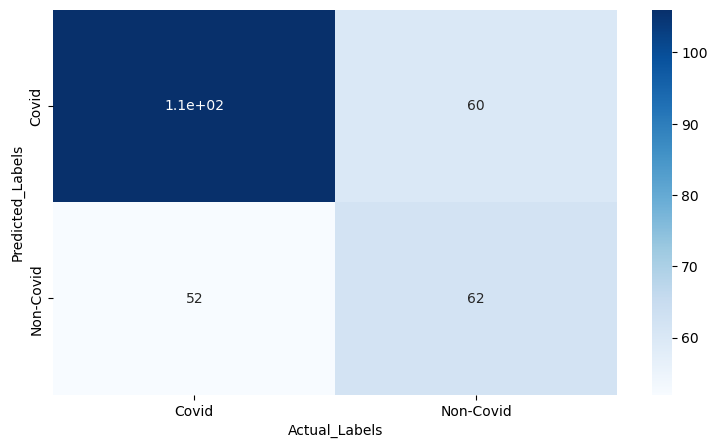

test accuracy = 60.0%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6
Precision: 0.5973
Recall: 0.6
F1 Score: 0.5982
25/25 [==============================] - 0s 13ms/step


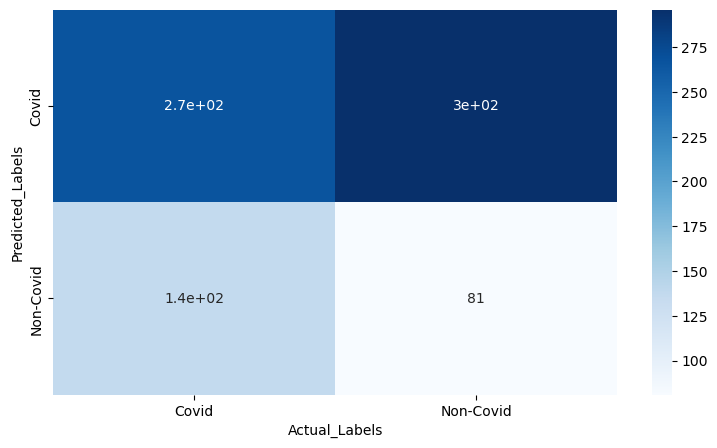

test accuracy = 44.48717948717948%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4449
Precision: 0.4241
Recall: 0.4449
F1 Score: 0.4164
9/9 [==============================] - 0s 13ms/step


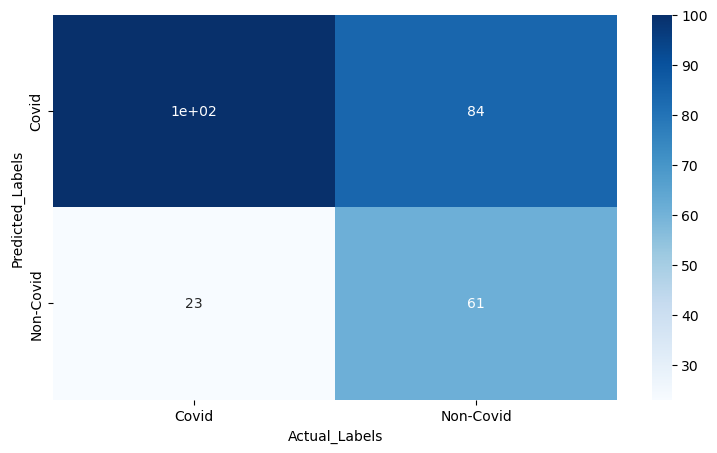

test accuracy = 60.07462686567165%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6007
Precision: 0.6423
Recall: 0.6007
F1 Score: 0.5872


In [ ]:
# X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
#                                   test_features_dataset3_fed), axis=0)
# y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
#                                   test_labels_dataset3_fed), axis=0)
getModelEvaluation(student_inital_model,test_features_dataset1_fed,test_labels_dataset1_fed)
getModelEvaluation(student_inital_model,test_features_dataset2_fed,test_labels_dataset2_fed)
getModelEvaluation(student_inital_model,test_features_dataset3_fed,test_labels_dataset3_fed)

## FedAvg StudentMod_only Experiments

- federated_train_data_nonIID_unbalanced [1120, 3119, 1071]
- federated_train_data_nonIID_balanced [1120, 3119, 1071]
- federated_train_data_IID_unbalanced [1120, 1200, 1071]
- federated_train_data_IID_balanced [1120, 1200, 1071]

### federated_train_data_nonIID_unbalanced

In [ ]:
from tqdm import tqdm
import time
#teacher_weights = [[1.7,0.85,0.85],[0.6,1.2,0.6], [0.80,0.80,1.6]]#[[0.6,0.3,0.10],[0.30,0.60,0.10], [0.10,0.10,0.80]]
teacher_weights = [[0.7, 0.15,0.15],[0.15, 0.7,0.15], [0.15, 0.15,0.7]]#[[0.6,0.3,0.10],[0.30,0.60,0.10], [0.20,0.20,0.60]]#[[1,0.00001,0.00001],[0.00001,1,0.00001], [0.00001,0.00001,1]]
teacher_model_select = [[2.0,10.0,10.0],[10.0,2.0,10.0], [10.0,10.0,2.0]]
metrics_nonIID_unbalanced = {'loss':[],'accuracy':[]}
server_state = FL_MTKD_process.initialize()
for round in tqdm(range(50)):
    server_state = FL_MTKD_process.next(server_state, federated_train_data_nonIID_unbalanced,teacher_weights,teacher_model_select)
    FL_MTKD_model_nonIID_unbalanced = evaluate(server_state,combined_test_data)
    loss = list(FL_MTKD_model_nonIID_unbalanced.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_MTKD_model_nonIID_unbalanced.get_metrics_result().values())[1].numpy()
    metrics_nonIID_unbalanced['loss'].append(loss)
    metrics_nonIID_unbalanced['accuracy'].append(accuracy)
#FL_MTKD_model = evaluate(server_state,combined_test_data)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2024-06-09 15:08:16.112987: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-09 15:08:16.113071: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-09 15:08:16.116837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-09 15:08:16.117051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14942 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-09 15:08:16.117256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14942 MB m

67/67 [==============================] - 1s 11ms/step - loss: 3.7104 - categorical_accuracy: 0.4849


  2%|▊                                        | 1/50 [11:59<9:47:27, 719.34s/it]

67/67 [==============================] - 1s 10ms/step - loss: 1.9656 - categorical_accuracy: 0.5060


  4%|█▋                                       | 2/50 [19:55<7:40:50, 576.06s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6779 - categorical_accuracy: 0.6852


  6%|██▍                                      | 3/50 [27:50<6:55:24, 530.32s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5914 - categorical_accuracy: 0.6634


  8%|███▎                                     | 4/50 [35:46<6:29:51, 508.52s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7708 - categorical_accuracy: 0.5580


 10%|████                                     | 5/50 [43:41<6:12:27, 496.61s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6897 - categorical_accuracy: 0.6077


 12%|████▉                                    | 6/50 [51:37<5:59:02, 489.61s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6438 - categorical_accuracy: 0.7357


 14%|█████▋                                   | 7/50 [59:32<5:47:25, 484.79s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7328 - categorical_accuracy: 0.7681


 16%|██████▏                                | 8/50 [1:07:28<5:37:21, 481.95s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.8206 - categorical_accuracy: 0.7620


 18%|███████                                | 9/50 [1:15:23<5:27:57, 479.94s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6693 - categorical_accuracy: 0.7703


 20%|███████▌                              | 10/50 [1:23:19<5:19:06, 478.67s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.6526 - categorical_accuracy: 0.7508


 22%|████████▎                             | 11/50 [1:31:14<5:10:27, 477.63s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7608 - categorical_accuracy: 0.7432


 24%|█████████                             | 12/50 [1:39:10<5:02:09, 477.09s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.7428 - categorical_accuracy: 0.7530


 26%|█████████▉                            | 13/50 [1:47:05<4:53:44, 476.34s/it]

67/67 [==============================] - 1s 11ms/step - loss: 2.0769 - categorical_accuracy: 0.7605


 28%|██████████▋                           | 14/50 [1:55:01<4:45:40, 476.13s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7954 - categorical_accuracy: 0.7101


 30%|███████████▍                          | 15/50 [2:02:56<4:37:37, 475.92s/it]

67/67 [==============================] - 1s 11ms/step - loss: 2.7665 - categorical_accuracy: 0.5218


 32%|████████████▏                         | 16/50 [2:10:51<4:29:35, 475.75s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.1579 - categorical_accuracy: 0.6724


 34%|████████████▉                         | 17/50 [2:18:47<4:21:41, 475.79s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.0250 - categorical_accuracy: 0.7892


 36%|█████████████▋                        | 18/50 [2:26:44<4:13:52, 476.02s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.5790 - categorical_accuracy: 0.7515


 38%|██████████████▍                       | 19/50 [2:34:40<4:05:56, 476.02s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.8052 - categorical_accuracy: 0.7877


 40%|███████████████▏                      | 20/50 [2:42:36<3:58:03, 476.13s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4934 - categorical_accuracy: 0.8170


 42%|███████████████▉                      | 21/50 [2:50:32<3:50:03, 475.97s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5933 - categorical_accuracy: 0.7997


 44%|████████████████▋                     | 22/50 [2:58:28<3:42:06, 475.95s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5520 - categorical_accuracy: 0.8095


 46%|█████████████████▍                    | 23/50 [3:06:24<3:34:10, 475.95s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7628 - categorical_accuracy: 0.8042


 48%|██████████████████▏                   | 24/50 [3:14:19<3:26:10, 475.79s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6831 - categorical_accuracy: 0.8193


 50%|███████████████████                   | 25/50 [3:22:15<3:18:13, 475.75s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5349 - categorical_accuracy: 0.8283


 52%|███████████████████▊                  | 26/50 [3:30:11<3:10:24, 476.03s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5064 - categorical_accuracy: 0.8366


 54%|████████████████████▌                 | 27/50 [3:38:07<3:02:25, 475.87s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7482 - categorical_accuracy: 0.7952


 56%|█████████████████████▎                | 28/50 [3:46:03<2:54:30, 475.95s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7486 - categorical_accuracy: 0.7967


 58%|██████████████████████                | 29/50 [3:53:59<2:46:38, 476.10s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.6770 - categorical_accuracy: 0.8072


 60%|██████████████████████▊               | 30/50 [4:01:56<2:38:42, 476.12s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7635 - categorical_accuracy: 0.8012


 62%|███████████████████████▌              | 31/50 [4:09:51<2:30:43, 475.99s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7104 - categorical_accuracy: 0.8072


 64%|████████████████████████▎             | 32/50 [4:17:48<2:22:49, 476.10s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6255 - categorical_accuracy: 0.8298


 66%|█████████████████████████             | 33/50 [4:25:44<2:14:55, 476.22s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5284 - categorical_accuracy: 0.8389


 68%|█████████████████████████▊            | 34/50 [4:33:40<2:06:58, 476.18s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.4832 - categorical_accuracy: 0.8456


 70%|██████████████████████████▌           | 35/50 [4:41:37<1:59:07, 476.48s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.4478 - categorical_accuracy: 0.8517


 72%|███████████████████████████▎          | 36/50 [4:49:34<1:51:11, 476.51s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4710 - categorical_accuracy: 0.8486


 74%|████████████████████████████          | 37/50 [4:57:30<1:43:13, 476.39s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.4974 - categorical_accuracy: 0.8411


 76%|████████████████████████████▉         | 38/50 [5:05:27<1:35:17, 476.43s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4887 - categorical_accuracy: 0.8404


 78%|█████████████████████████████▋        | 39/50 [5:13:23<1:27:20, 476.37s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5281 - categorical_accuracy: 0.8283


 80%|██████████████████████████████▍       | 40/50 [5:21:18<1:19:20, 476.02s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5978 - categorical_accuracy: 0.8208


 82%|███████████████████████████████▏      | 41/50 [5:29:14<1:11:23, 475.93s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.6564 - categorical_accuracy: 0.7982


 84%|███████████████████████████████▉      | 42/50 [5:37:10<1:03:28, 476.04s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5183 - categorical_accuracy: 0.8223


 86%|██████████████████████████████████▍     | 43/50 [5:45:06<55:31, 475.90s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5193 - categorical_accuracy: 0.8283


 88%|███████████████████████████████████▏    | 44/50 [5:53:01<47:35, 475.84s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.6243 - categorical_accuracy: 0.8306


 90%|████████████████████████████████████    | 45/50 [6:00:57<39:38, 475.70s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7893 - categorical_accuracy: 0.8005


 92%|████████████████████████████████████▊   | 46/50 [6:08:52<31:42, 475.59s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7676 - categorical_accuracy: 0.8065


 94%|█████████████████████████████████████▌  | 47/50 [6:16:47<23:46, 475.44s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5762 - categorical_accuracy: 0.8185


 96%|██████████████████████████████████████▍ | 48/50 [6:24:43<15:51, 475.68s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4899 - categorical_accuracy: 0.8351


 98%|███████████████████████████████████████▏| 49/50 [6:32:39<07:55, 475.73s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4859 - categorical_accuracy: 0.8351


100%|████████████████████████████████████████| 50/50 [6:40:36<00:00, 480.73s/it]


In [ ]:
print('loss: ',FL_MTKD_model_nonIID_unbalanced.get_metrics_result()['loss'].numpy())
print('Accuracy: ',FL_MTKD_model_nonIID_unbalanced.get_metrics_result()['categorical_accuracy'].numpy())

loss:  0.48593003
Accuracy:  0.83509034


--------------------- Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 13ms/step


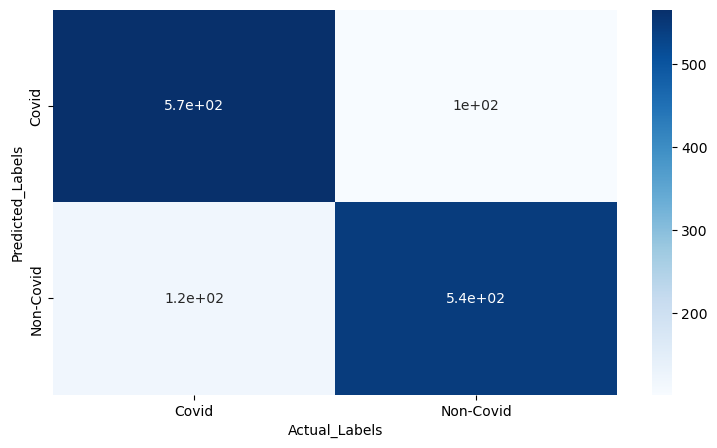

test accuracy = 83.5090361445783%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8351
Precision: 0.8354
Recall: 0.8351
F1 Score: 0.8351


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_unbalanced,X_test_combined,y_test_combined)

In [ ]:
FL_MTKD_model_nonIID_unbalanced.save('gsm_noniid_unbalanced.h5')
FL_MTKD_model_nonIID_unbalanced = tf.keras.models.load_model('gsm_noniid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 13ms/step


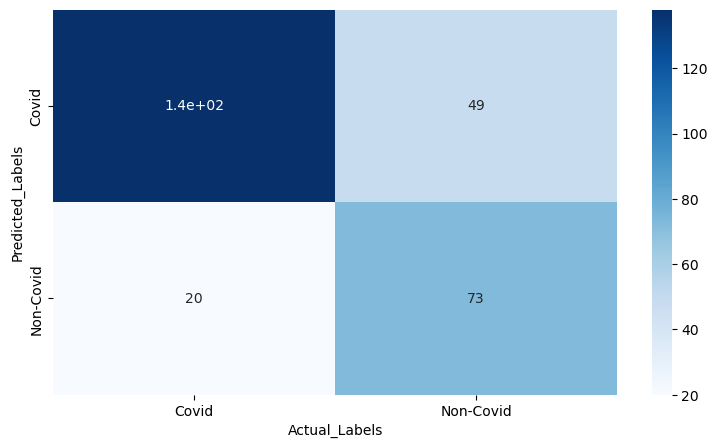

test accuracy = 75.35714285714286%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7536
Precision: 0.7584
Recall: 0.7536
F1 Score: 0.7473
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 0s 13ms/step


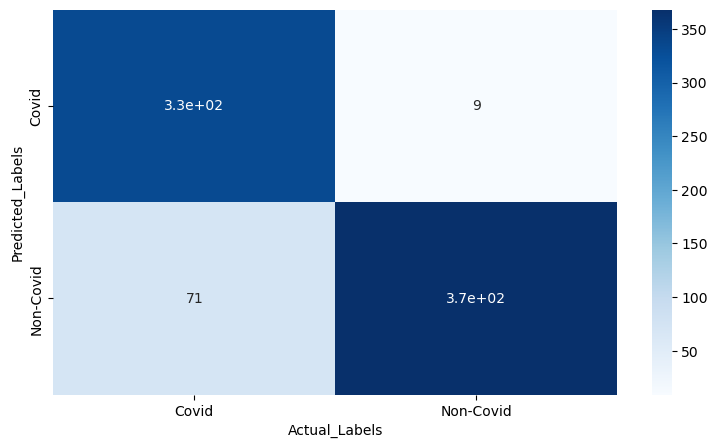

test accuracy = 89.74358974358975%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8974
Precision: 0.9082
Recall: 0.8974
F1 Score: 0.8971
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 14ms/step


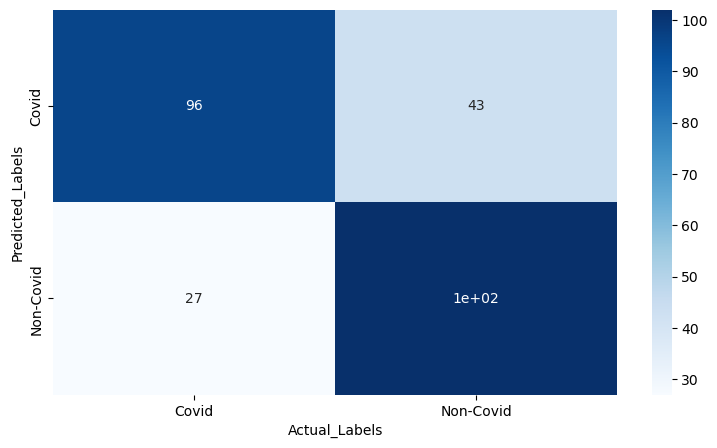

test accuracy = 73.88059701492537%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7388
Precision: 0.7448
Recall: 0.7388
F1 Score: 0.7392


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_unbalanced,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_unbalanced,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_unbalanced,test_features_dataset3_fed,test_labels_dataset3_fed)

### federated_train_data_nonIID_balanced

In [ ]:
server_state = FL_MTKD_process.initialize()
#teacher_weights = [[1.7,0.85,0.85],[0.6,1.2,0.6], [0.80,0.80,1.6]]
teacher_weights = [[0.7, 0.15,0.15],[0.15, 0.7,0.15], [0.15, 0.15,0.7]]#[[0.6,0.3,0.10],[0.30,0.60,0.10], [0.20,0.20,0.60]]#[[1,0.00001,0.00001],[0.00001,1,0.00001], [0.00001,0.00001,1]]
teacher_model_select = [[2.0,10.0,10.0],[10.0,2.0,10.0], [10.0,10.0,2.0]]
metrics_nonIID_balanced = {'loss':[],'accuracy':[]}
for round in tqdm(range(50)):
    server_state = FL_MTKD_process.next(server_state, federated_train_data_nonIID_balanced,teacher_weights,teacher_model_select)
    FL_MTKD_model_nonIID_balanced = evaluate(server_state,combined_test_data)
    loss = list(FL_MTKD_model_nonIID_balanced.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_MTKD_model_nonIID_balanced.get_metrics_result().values())[1].numpy()
    metrics_nonIID_balanced['loss'].append(loss)
    metrics_nonIID_balanced['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 1s 10ms/step - loss: 5.5370 - categorical_accuracy: 0.4849


  2%|▊                                        | 1/50 [05:06<4:10:07, 306.28s/it]

67/67 [==============================] - 1s 10ms/step - loss: 3.2656 - categorical_accuracy: 0.4857


  4%|█▋                                       | 2/50 [10:09<4:03:27, 304.32s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.6556 - categorical_accuracy: 0.6883


  6%|██▍                                      | 3/50 [15:09<3:57:04, 302.65s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5670 - categorical_accuracy: 0.7711


  8%|███▎                                     | 4/50 [20:11<3:51:35, 302.07s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5672 - categorical_accuracy: 0.7176


 10%|████                                     | 5/50 [25:12<3:46:21, 301.80s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6033 - categorical_accuracy: 0.6544


 12%|████▉                                    | 6/50 [30:12<3:41:01, 301.39s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6812 - categorical_accuracy: 0.6310


 14%|█████▋                                   | 7/50 [35:14<3:35:59, 301.37s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6605 - categorical_accuracy: 0.6581


 16%|██████▌                                  | 8/50 [40:16<3:31:03, 301.52s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6695 - categorical_accuracy: 0.7259


 18%|███████▍                                 | 9/50 [45:17<3:26:01, 301.49s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6241 - categorical_accuracy: 0.7590


 20%|████████                                | 10/50 [50:18<3:20:55, 301.39s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6080 - categorical_accuracy: 0.7620


 22%|████████▊                               | 11/50 [55:19<3:15:45, 301.17s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5959 - categorical_accuracy: 0.7613


 24%|█████████                             | 12/50 [1:00:19<3:10:37, 300.98s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5626 - categorical_accuracy: 0.7718


 26%|█████████▉                            | 13/50 [1:05:21<3:05:44, 301.21s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5331 - categorical_accuracy: 0.7952


 28%|██████████▋                           | 14/50 [1:10:22<3:00:37, 301.04s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5340 - categorical_accuracy: 0.7877


 30%|███████████▍                          | 15/50 [1:15:23<2:55:34, 300.99s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5876 - categorical_accuracy: 0.7568


 32%|████████████▏                         | 16/50 [1:20:24<2:50:38, 301.13s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6327 - categorical_accuracy: 0.7620


 34%|████████████▉                         | 17/50 [1:25:25<2:45:33, 301.01s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5966 - categorical_accuracy: 0.7952


 36%|█████████████▋                        | 18/50 [1:30:26<2:40:35, 301.11s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5593 - categorical_accuracy: 0.8027


 38%|██████████████▍                       | 19/50 [1:35:28<2:35:39, 301.28s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5433 - categorical_accuracy: 0.8095


 40%|███████████████▏                      | 20/50 [1:40:29<2:30:37, 301.26s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5275 - categorical_accuracy: 0.8223


 42%|███████████████▉                      | 21/50 [1:45:30<2:25:37, 301.28s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5303 - categorical_accuracy: 0.8170


 44%|████████████████▋                     | 22/50 [1:50:32<2:20:38, 301.38s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5241 - categorical_accuracy: 0.8080


 46%|█████████████████▍                    | 23/50 [1:55:33<2:15:32, 301.20s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5154 - categorical_accuracy: 0.7982


 48%|██████████████████▏                   | 24/50 [2:00:34<2:10:27, 301.07s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5108 - categorical_accuracy: 0.7929


 50%|███████████████████                   | 25/50 [2:05:35<2:05:26, 301.08s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5121 - categorical_accuracy: 0.7952


 52%|███████████████████▊                  | 26/50 [2:10:36<2:00:24, 301.02s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5184 - categorical_accuracy: 0.8050


 54%|████████████████████▌                 | 27/50 [2:15:36<1:55:22, 300.98s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5333 - categorical_accuracy: 0.8035


 56%|█████████████████████▎                | 28/50 [2:20:38<1:50:25, 301.15s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5531 - categorical_accuracy: 0.8012


 58%|██████████████████████                | 29/50 [2:25:40<1:45:27, 301.29s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5650 - categorical_accuracy: 0.8065


 60%|██████████████████████▊               | 30/50 [2:30:41<1:40:24, 301.22s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5398 - categorical_accuracy: 0.8110


 62%|███████████████████████▌              | 31/50 [2:35:42<1:35:22, 301.19s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5366 - categorical_accuracy: 0.8148


 64%|████████████████████████▎             | 32/50 [2:40:43<1:30:21, 301.21s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5095 - categorical_accuracy: 0.8140


 66%|█████████████████████████             | 33/50 [2:45:44<1:25:21, 301.25s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4852 - categorical_accuracy: 0.8321


 68%|█████████████████████████▊            | 34/50 [2:50:46<1:20:20, 301.30s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4722 - categorical_accuracy: 0.8291


 70%|██████████████████████████▌           | 35/50 [2:55:47<1:15:19, 301.31s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4687 - categorical_accuracy: 0.8170


 72%|███████████████████████████▎          | 36/50 [3:00:49<1:10:18, 301.32s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4734 - categorical_accuracy: 0.8163


 74%|████████████████████████████          | 37/50 [3:05:49<1:05:15, 301.18s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4826 - categorical_accuracy: 0.8125


 76%|████████████████████████████▉         | 38/50 [3:10:50<1:00:13, 301.09s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4839 - categorical_accuracy: 0.8185


 78%|███████████████████████████████▏        | 39/50 [3:15:51<55:12, 301.13s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4832 - categorical_accuracy: 0.8238


 80%|████████████████████████████████        | 40/50 [3:20:52<50:10, 301.01s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4911 - categorical_accuracy: 0.8215


 82%|████████████████████████████████▊       | 41/50 [3:25:54<45:10, 301.12s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4938 - categorical_accuracy: 0.8072


 84%|█████████████████████████████████▌      | 42/50 [3:30:55<40:09, 301.17s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5408 - categorical_accuracy: 0.7786


 86%|██████████████████████████████████▍     | 43/50 [3:35:55<35:07, 301.00s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5508 - categorical_accuracy: 0.7666


 88%|███████████████████████████████████▏    | 44/50 [3:40:56<30:05, 300.94s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5589 - categorical_accuracy: 0.7869


 90%|████████████████████████████████████    | 45/50 [3:45:58<25:05, 301.20s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6028 - categorical_accuracy: 0.7779


 92%|████████████████████████████████████▊   | 46/50 [3:50:59<20:04, 301.20s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5478 - categorical_accuracy: 0.8042


 94%|█████████████████████████████████████▌  | 47/50 [3:56:00<15:03, 301.05s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5243 - categorical_accuracy: 0.8065


 96%|██████████████████████████████████████▍ | 48/50 [4:01:01<10:02, 301.19s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5125 - categorical_accuracy: 0.8065


 98%|███████████████████████████████████████▏| 49/50 [4:06:03<05:01, 301.24s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5076 - categorical_accuracy: 0.8155


100%|████████████████████████████████████████| 50/50 [4:11:04<00:00, 301.29s/it]


In [ ]:
print('loss: ',FL_MTKD_model_nonIID_balanced.get_metrics_result()['loss'].numpy())
print('Accuracy: ',FL_MTKD_model_nonIID_balanced.get_metrics_result()['categorical_accuracy'].numpy())

loss:  0.507646
Accuracy:  0.81551206


--------------------- Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 14ms/step


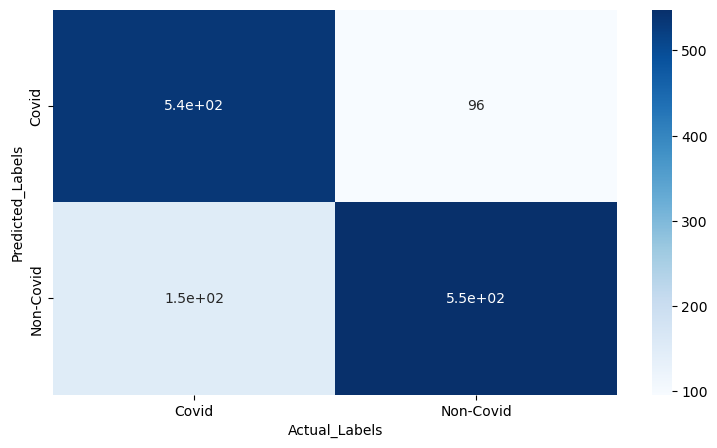

test accuracy = 81.55120481927712%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8155
Precision: 0.818
Recall: 0.8155
F1 Score: 0.8154


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_balanced,X_test_combined,y_test_combined)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 13ms/step


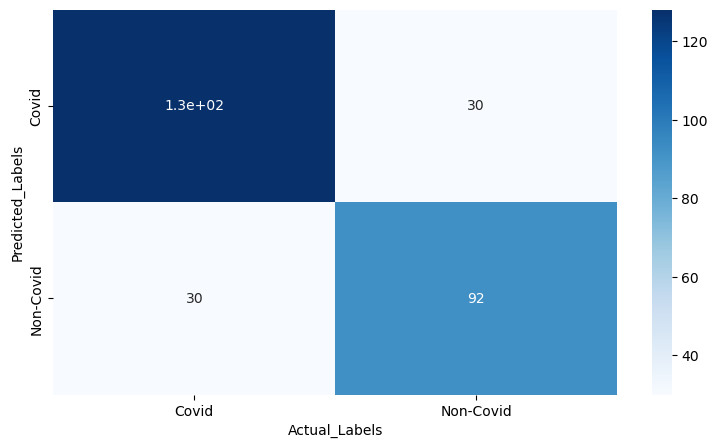

test accuracy = 78.57142857142857%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7857
Precision: 0.7857
Recall: 0.7857
F1 Score: 0.7857
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 0s 13ms/step


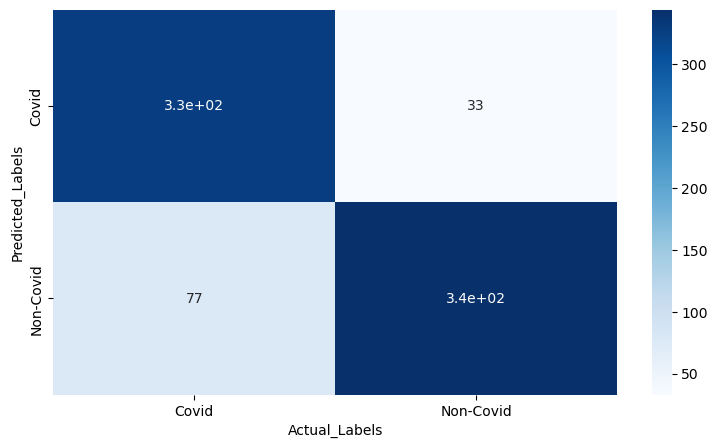

test accuracy = 85.8974358974359%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.859
Precision: 0.8641
Recall: 0.859
F1 Score: 0.8588
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 13ms/step


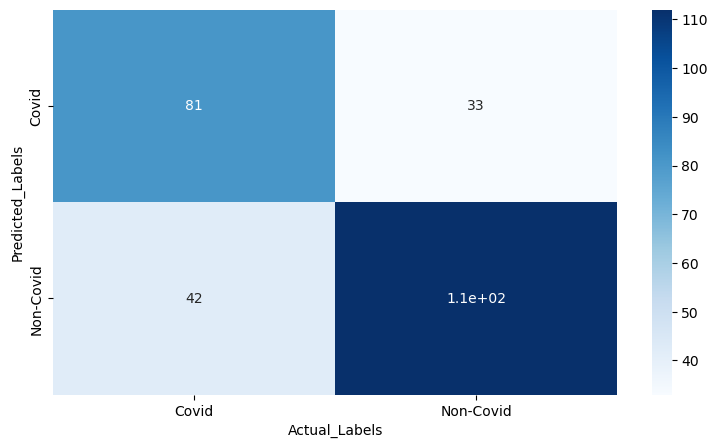

test accuracy = 72.01492537313433%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7201
Precision: 0.7196
Recall: 0.7201
F1 Score: 0.719


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_balanced,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_balanced,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_nonIID_balanced,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
FL_MTKD_model_nonIID_balanced.save('gsm_noniid_balanced.h5')

### federated_train_data_IID_unbalanced

In [ ]:
#1. Server and client optimizer to be used.
server_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=1.0, momentum=0.9)#lr = 0.01 last run was 0.01 and acc was 74.12 # lr =0.05 momentum = 0.5
# client_optimizer = tff.learning.optimizers.build_sgdm(
#     learning_rate=0.001)
# client_optimizer = tff.learning.optimizers.build_adagrad(
#     learning_rate = 0.01)
client_optimizer = tff.learning.optimizers.build_adam(learning_rate = 0.0001, beta_1 = 0.9,beta_2 = 0.99,
    epsilon = 1e-07
)
#client_optimizer = tff.learning.optimizers.build_adam(learning_rate = 0.001)

In [ ]:
@tff.tensorflow.computation(tf_dataset_type, trainable_weights_type,teacher_weights_type)
def client_update_fn(tf_dataset, server_weights,teacher_weights):

    # Instantiate the student model using model_fn
    student_model = model_fn()

    # Instantiate the teacher model using model_fn_teacher (CNN)
    model_teacher = tf.keras.models.load_model('teacher_CNN_model_dataset2.h5')#load_model("teacher_CNN_model.h5")
    model_teacher_weight = model_teacher.get_weights()
    CNNModel_teacher = COVIDCNN_model_fn_teacher(model_teacher_weight)#model_fn_teacher()

    # Instantiate the teacher model using DEEPCOVID_model_fn_teacher
    model_teacher = tf.keras.models.load_model('Deep_COVID_teacher_model.h5')
    model_teacher_weight = model_teacher.get_weights()
    DEEPCOVIDModel_teacher = DEEPCOVID_model_fn_teacher(model_teacher_weight)

    # Instantiate the teacher model using DCD_model_fn_teacher
    model_teacher = tf.keras.models.load_model('CNN_Mod_VGG16_teacher_model_dataset2.h5')
    model_teacher_weight = model_teacher.get_weights()
    CNN_Mod_VGG16_teacher = CNN_Mod_VGG16_fn_teacher(model_teacher_weight)


    # Instantiate the Distiller with the student and teacher models
    optimizer = client_optimizer

    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    distillation_loss_fn=tf.keras.losses.KLDivergence()

    #initial alpha = 0.5 and temperature = 3, was 10
    distiller = Distiller_FL_MTKD(optimizer,0.6,10,student_loss_fn,distillation_loss_fn,
                         student=student_model,
                        teachers=[CNNModel_teacher,DEEPCOVIDModel_teacher,CNN_Mod_VGG16_teacher])#,CNN_Mod_VGG16_teacher teach_weights = weights_


    # Perform training on the client's dataset using the Distiller
    updated_student_weights = distiller.client_update(tf_dataset, server_weights,teacher_weights)#we don't need tf_clientId here

    return updated_student_weights

# 3-2. Orchestration with `tff.federated_computation`.
federated_server_type = tff.FederatedType(server_state_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
federated_teacher_weights_type = tff.FederatedType(teacher_weights_type, tff.CLIENTS)

@tff.federated_computation(federated_server_type, federated_dataset_type,federated_teacher_weights_type)
def run_one_round(server_state, federated_dataset,federated_teacher_weights):
    # Server-to-client broadcast.
    server_weights_at_client = tff.federated_broadcast(
      server_state.trainable_weights)
    # Local client update.
    model_deltas = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client,federated_teacher_weights))
    # Client-to-server upload and aggregation.
    mean_model_delta = tff.federated_mean(model_deltas)
    # Server update.
    server_state = tff.federated_map(
      server_update_fn, (server_state, mean_model_delta))
    return server_state

# 4. Build the iterative process for FedAvg.
FL_MTKD_process = tff.templates.IterativeProcess(
    initialize_fn=server_init_tff, next_fn=run_one_round)
print('type signature of `initialize`:\n',
      FL_MTKD_process.initialize.type_signature.formatted_representation())
print('type signature of `next`:\n',
      FL_MTKD_process.next.type_signature.formatted_representation())

def map_function(input_data, target_data):
    # Apply any necessary transformations to input_data and target_data here
    # For example, you can cast the target_data to a different dtype if needed
    target_data = tf.cast(target_data, tf.float32)
    return input_data, target_data

test_data = [(X_test_combined,y_test_combined )]
test_datasets = [create_tf_dataset_for_client(data) for data in test_data]
combined_test_data = [preprocess_dataset(dataset) for dataset in test_datasets]
combined_test_data = combined_test_data[0].map(map_function)

def evaluate(server_state, dataset):
    keras_model = create_simpCNN_model()
    #student_model = tf.keras.models.load_model('student_CNN_model.h5')
    #model_student_weight = student_model.get_weights()
    #keras_model.set_weights(model_student_weight)
    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    keras_model.set_weights(server_state.trainable_weights)
    keras_model.evaluate(dataset,verbose=1)
    return keras_model

server_state = FL_MTKD_process.initialize()
student_inital_model = evaluate(server_state, combined_test_data)
print('loss: ',student_inital_model.get_metrics_result()['loss'].numpy())
print('Accuracy: ',student_inital_model.get_metrics_result()['categorical_accuracy'].numpy())

2024-06-10 09:27:42.062396: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_1/kernel/Assign' id:687 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1_1/kernel, dense_1_1/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-10 09:27:42.797498: W tensorflow/c/c_api.cc:305] Operation '{name:'count_2/Assign' id:901 op device:{requested: '', assigned: ''} def:{{{node count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_2, count_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in t

Pre-train Epoch 1/1
Pre-train Epoch 1, Loss: Tensor("Sum:0", shape=(), dtype=float32)
Train Epoch 2/2
Epoch 2, Loss: Tensor("add:0", shape=(), dtype=float32)
type signature of `initialize`:
 ( -> <
  trainable_weights=<
    float32[3,3,1,32],
    float32[32],
    float32[313632,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >
  >
>@SERVER)
type signature of `next`:
 (<
  server_state=<
    trainable_weights=<
      float32[3,3,1,32],
      float32[32],
      float32[313632,2],
      float32[2]
    >,
    optimizer_state=<
      learning_rate=float32,
      momentum=float32,
      accumulator=<
        float32[3,3,1,32],
        float32[32],
        float32[313632,2],
        float32[2]
      >
    >
  >@SERVER,
  federated_dataset={<
    float64[?,200,200,1],
    uint8[?,2]
  >*}@CLIENTS,
  federated_teacher_weights={float32[3]}@CLIEN

In [ ]:
X_test_combined_iid = np.concatenate((test_features_dataset1_fed_iid, test_features_dataset2_fed_iid,
                                  test_features_dataset3_fed_iid), axis=0)
y_test_combined_iid = np.concatenate((test_labels_dataset1_fed_iid, test_labels_dataset2_fed_iid,
                                  test_labels_dataset3_fed_iid), axis=0)
test_data_iid = [(X_test_combined_iid,y_test_combined_iid )]
test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
server_state = FL_MTKD_process.initialize()
teacher_weights = [[0.4, 0.4,0.2],[0.4, 0.4,0.2], [0.4, 0.4,0.2]]#[[0.6,0.3,0.10],[0.30,0.60,0.10], [0.20,0.20,0.60]]#[[1,0.00001,0.00001],[0.00001,1,0.00001], [0.00001,0.00001,1]]
teacher_model_select = [[2.0,10.0,10.0],[10.0,2.0,10.0], [0.4, 0.4,0.2]]
metrics_IID_unbalanced = {'loss':[],'accuracy':[]}
for round in tqdm(range(50)):
    server_state = FL_MTKD_process.next(server_state, federated_train_data_IID_unbalanced,teacher_weights,teacher_model_select)
    FL_MTKD_model_IID_unbalanced = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_MTKD_model_IID_unbalanced.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_MTKD_model_IID_unbalanced.get_metrics_result().values())[1].numpy()
    metrics_IID_unbalanced['loss'].append(loss)
    metrics_IID_unbalanced['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2024-06-10 09:29:32.258936: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-10 09:29:32.259061: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-10 09:29:32.262754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-10 09:29:32.262984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14942 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-10 09:29:32.263188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14942 MB m

67/67 [==============================] - 1s 11ms/step - loss: 0.4291 - categorical_accuracy: 0.8321


  2%|▊                                        | 1/50 [12:00<9:48:05, 720.12s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4788 - categorical_accuracy: 0.8652


  4%|█▋                                       | 2/50 [19:56<7:41:09, 576.46s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6037 - categorical_accuracy: 0.7982


  6%|██▍                                      | 3/50 [27:51<6:55:29, 530.40s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.7127 - categorical_accuracy: 0.6250


  8%|███▎                                     | 4/50 [35:46<6:29:56, 508.62s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4294 - categorical_accuracy: 0.7974


 10%|████                                     | 5/50 [43:42<6:12:28, 496.64s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6643 - categorical_accuracy: 0.6002


 12%|████▉                                    | 6/50 [51:37<5:58:55, 489.44s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.4105 - categorical_accuracy: 0.5248


 14%|█████▋                                   | 7/50 [59:33<5:47:28, 484.84s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4765 - categorical_accuracy: 0.7327


 16%|██████▏                                | 8/50 [1:07:29<5:37:30, 482.17s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2897 - categorical_accuracy: 0.9029


 18%|███████                                | 9/50 [1:15:24<5:28:02, 480.05s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3657 - categorical_accuracy: 0.8336


 20%|███████▌                              | 10/50 [1:23:20<5:19:12, 478.82s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.6612 - categorical_accuracy: 0.5324


 22%|████████▎                             | 11/50 [1:31:17<5:10:48, 478.16s/it]

67/67 [==============================] - 1s 11ms/step - loss: 2.3529 - categorical_accuracy: 0.5166


 24%|█████████                             | 12/50 [1:39:13<5:02:22, 477.44s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3770 - categorical_accuracy: 0.8072


 26%|█████████▉                            | 13/50 [1:47:08<4:53:59, 476.73s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6432 - categorical_accuracy: 0.8102


 28%|██████████▋                           | 14/50 [1:55:03<4:45:46, 476.29s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5835 - categorical_accuracy: 0.8027


 30%|███████████▍                          | 15/50 [2:02:59<4:37:41, 476.05s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3628 - categorical_accuracy: 0.8328


 32%|████████████▏                         | 16/50 [2:10:54<4:29:41, 475.94s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.5931 - categorical_accuracy: 0.7169


 34%|████████████▉                         | 17/50 [2:18:50<4:21:41, 475.79s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2093 - categorical_accuracy: 0.9217


 36%|█████████████▋                        | 18/50 [2:26:46<4:13:44, 475.77s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2209 - categorical_accuracy: 0.9255


 38%|██████████████▍                       | 19/50 [2:34:41<4:05:49, 475.79s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2190 - categorical_accuracy: 0.9172


 40%|███████████████▏                      | 20/50 [2:42:37<3:57:54, 475.83s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2322 - categorical_accuracy: 0.9127


 42%|███████████████▉                      | 21/50 [2:50:32<3:49:51, 475.57s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2280 - categorical_accuracy: 0.9270


 44%|████████████████▋                     | 22/50 [2:58:28<3:42:00, 475.73s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1930 - categorical_accuracy: 0.9375


 46%|█████████████████▍                    | 23/50 [3:06:24<3:34:06, 475.81s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1875 - categorical_accuracy: 0.9322


 48%|██████████████████▏                   | 24/50 [3:14:22<3:26:21, 476.22s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2320 - categorical_accuracy: 0.9164


 50%|███████████████████                   | 25/50 [3:22:19<3:18:33, 476.53s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3211 - categorical_accuracy: 0.8524


 52%|███████████████████▊                  | 26/50 [3:30:16<3:10:42, 476.76s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2527 - categorical_accuracy: 0.8810


 54%|████████████████████▌                 | 27/50 [3:38:13<3:02:43, 476.66s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1532 - categorical_accuracy: 0.9495


 56%|█████████████████████▎                | 28/50 [3:46:08<2:54:40, 476.40s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1506 - categorical_accuracy: 0.9495


 58%|██████████████████████                | 29/50 [3:54:04<2:46:41, 476.25s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1905 - categorical_accuracy: 0.9270


 60%|██████████████████████▊               | 30/50 [4:02:01<2:38:45, 476.27s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2242 - categorical_accuracy: 0.9096


 62%|███████████████████████▌              | 31/50 [4:09:57<2:30:49, 476.28s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1665 - categorical_accuracy: 0.9420


 64%|████████████████████████▎             | 32/50 [4:17:54<2:22:58, 476.59s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.1349 - categorical_accuracy: 0.9503


 66%|█████████████████████████             | 33/50 [4:25:51<2:15:01, 476.58s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.1334 - categorical_accuracy: 0.9465


 68%|█████████████████████████▊            | 34/50 [4:33:46<2:07:00, 476.30s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1499 - categorical_accuracy: 0.9413


 70%|██████████████████████████▌           | 35/50 [4:41:43<1:59:07, 476.47s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1719 - categorical_accuracy: 0.9300


 72%|███████████████████████████▎          | 36/50 [4:49:39<1:51:08, 476.30s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1664 - categorical_accuracy: 0.9398


 74%|████████████████████████████          | 37/50 [4:57:35<1:43:10, 476.16s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1601 - categorical_accuracy: 0.9360


 76%|████████████████████████████▉         | 38/50 [5:05:32<1:35:16, 476.34s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1400 - categorical_accuracy: 0.9548


 78%|█████████████████████████████▋        | 39/50 [5:13:29<1:27:21, 476.46s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1318 - categorical_accuracy: 0.9563


 80%|██████████████████████████████▍       | 40/50 [5:21:26<1:19:26, 476.63s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1380 - categorical_accuracy: 0.9495


 82%|███████████████████████████████▏      | 41/50 [5:29:21<1:11:26, 476.28s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1547 - categorical_accuracy: 0.9428


 84%|███████████████████████████████▉      | 42/50 [5:37:16<1:03:28, 476.01s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1723 - categorical_accuracy: 0.9383


 86%|██████████████████████████████████▍     | 43/50 [5:45:13<55:32, 476.10s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.1573 - categorical_accuracy: 0.9428


 88%|███████████████████████████████████▏    | 44/50 [5:53:08<47:35, 475.90s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1430 - categorical_accuracy: 0.9488


 90%|████████████████████████████████████    | 45/50 [6:01:04<39:39, 475.96s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1351 - categorical_accuracy: 0.9511


 92%|████████████████████████████████████▊   | 46/50 [6:09:00<31:43, 475.95s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1334 - categorical_accuracy: 0.9526


 94%|█████████████████████████████████████▌  | 47/50 [6:16:56<23:47, 475.78s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1389 - categorical_accuracy: 0.9488


 96%|██████████████████████████████████████▍ | 48/50 [6:24:51<15:51, 475.67s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1475 - categorical_accuracy: 0.9420


 98%|███████████████████████████████████████▏| 49/50 [6:32:47<07:55, 475.85s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.1663 - categorical_accuracy: 0.9398


100%|████████████████████████████████████████| 50/50 [6:40:43<00:00, 480.88s/it]


In [ ]:
print('loss: ',FL_MTKD_model_IID_unbalanced.get_metrics_result()['loss'].numpy())
print('Accuracy: ',FL_MTKD_model_IID_unbalanced.get_metrics_result()['categorical_accuracy'].numpy())

loss:  0.16628255
Accuracy:  0.939759


--------------------- Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 13ms/step


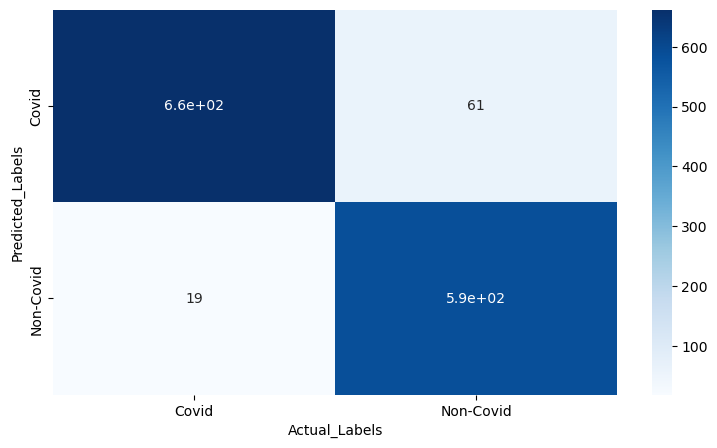

test accuracy = 93.97590361445783%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9398
Precision: 0.9414
Recall: 0.9398
F1 Score: 0.9396


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_unbalanced,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 13ms/step


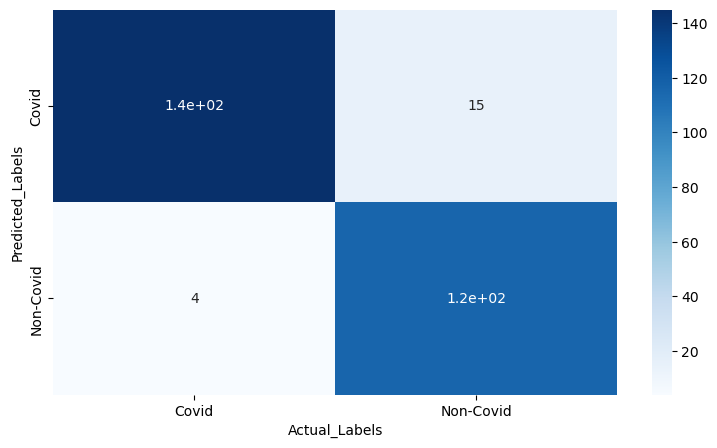

test accuracy = 93.21428571428572%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9321
Precision: 0.9345
Recall: 0.9321
F1 Score: 0.9319
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 0s 13ms/step


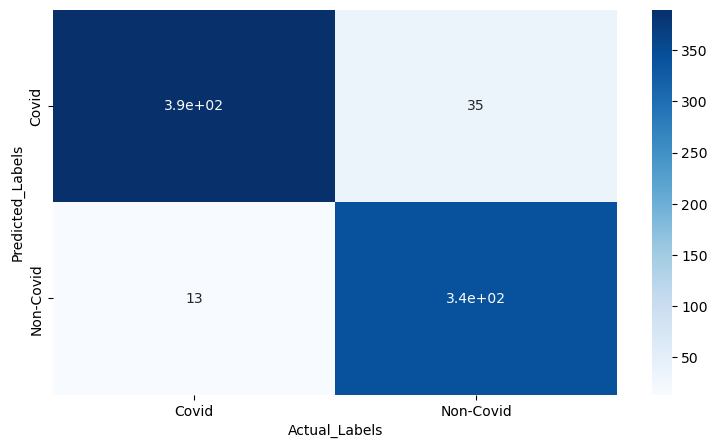

test accuracy = 93.84615384615384%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9385
Precision: 0.9398
Recall: 0.9385
F1 Score: 0.9384
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 13ms/step


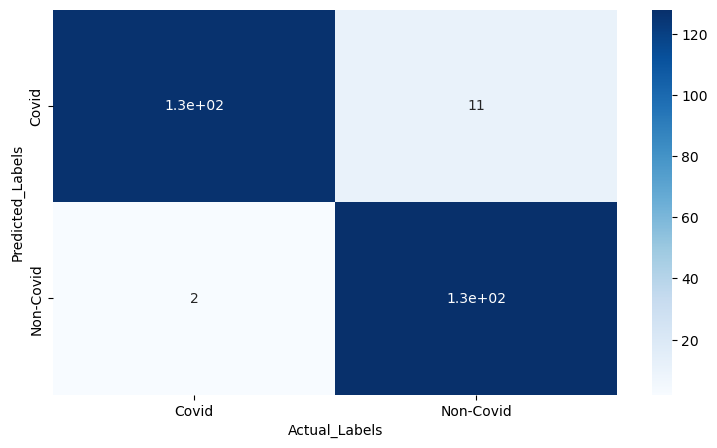

test accuracy = 95.1492537313433%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9515
Precision: 0.9537
Recall: 0.9515
F1 Score: 0.9515


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_unbalanced,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_unbalanced,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_unbalanced,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_MTKD_model_IID_unbalanced.save('gsm_iid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_balanced

In [ ]:
server_state = FL_MTKD_process.initialize()
teacher_weights = [[0.4, 0.4,0.2],[0.4, 0.4,0.2], [0.4, 0.4,0.2]]#[[0.6,0.3,0.10],[0.30,0.60,0.10], [0.20,0.20,0.60]]#[[1,0.00001,0.00001],[0.00001,1,0.00001], [0.00001,0.00001,1]]
teacher_model_select = [[2.0,10.0,10.0],[10.0,2.0,10.0], [10.0,10.0,2.0]]
metrics_IID_balanced = {'loss':[],'accuracy':[]}
for round in tqdm(range(50)):
    server_state = FL_MTKD_process.next(server_state, federated_train_data_IID_balanced, teacher_weights,teacher_model_select)
    FL_MTKD_model_IID_balanced = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_MTKD_model_IID_balanced.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_MTKD_model_IID_balanced.get_metrics_result().values())[1].numpy()
    metrics_IID_balanced['loss'].append(loss)
    metrics_IID_balanced['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 1s 11ms/step - loss: 0.4574 - categorical_accuracy: 0.8306


  2%|▊                                        | 1/50 [05:01<4:06:11, 301.46s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4869 - categorical_accuracy: 0.8313


  4%|█▋                                       | 2/50 [10:03<4:01:13, 301.52s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4389 - categorical_accuracy: 0.8758


  6%|██▍                                      | 3/50 [15:03<3:55:55, 301.19s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5938 - categorical_accuracy: 0.6928


  8%|███▎                                     | 4/50 [20:04<3:50:53, 301.17s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6162 - categorical_accuracy: 0.6303


 10%|████                                     | 5/50 [25:06<3:46:01, 301.36s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3595 - categorical_accuracy: 0.8750


 12%|████▉                                    | 6/50 [30:07<3:40:57, 301.30s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.0834 - categorical_accuracy: 0.5173


 14%|█████▋                                   | 7/50 [35:08<3:35:52, 301.23s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.2566 - categorical_accuracy: 0.5211


 16%|██████▌                                  | 8/50 [40:10<3:30:52, 301.25s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4664 - categorical_accuracy: 0.7364


 18%|███████▍                                 | 9/50 [45:11<3:25:53, 301.31s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3628 - categorical_accuracy: 0.8878


 20%|████████                                | 10/50 [50:13<3:20:57, 301.45s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.3564 - categorical_accuracy: 0.9036


 22%|████████▊                               | 11/50 [55:14<3:15:53, 301.38s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.3233 - categorical_accuracy: 0.8682


 24%|█████████                             | 12/50 [1:00:17<3:11:04, 301.70s/it]

67/67 [==============================] - 1s 11ms/step - loss: 1.0546 - categorical_accuracy: 0.5309


 26%|█████████▉                            | 13/50 [1:05:19<3:06:11, 301.94s/it]

67/67 [==============================] - 1s 10ms/step - loss: 1.0226 - categorical_accuracy: 0.5392


 28%|██████████▋                           | 14/50 [1:10:21<3:01:10, 301.97s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3008 - categorical_accuracy: 0.9051


 30%|███████████▍                          | 15/50 [1:15:23<2:56:09, 301.98s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5992 - categorical_accuracy: 0.7583


 32%|████████████▏                         | 16/50 [1:20:25<2:51:10, 302.08s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3490 - categorical_accuracy: 0.9096


 34%|████████████▉                         | 17/50 [1:25:27<2:45:59, 301.82s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.5686 - categorical_accuracy: 0.6145


 36%|█████████████▋                        | 18/50 [1:30:28<2:40:52, 301.65s/it]

67/67 [==============================] - 1s 10ms/step - loss: 1.3054 - categorical_accuracy: 0.5218


 38%|██████████████▍                       | 19/50 [1:35:30<2:35:56, 301.82s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.4892 - categorical_accuracy: 0.6604


 40%|███████████████▏                      | 20/50 [1:40:31<2:30:49, 301.66s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.3650 - categorical_accuracy: 0.8968


 42%|███████████████▉                      | 21/50 [1:45:33<2:25:48, 301.67s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3854 - categorical_accuracy: 0.8908


 44%|████████████████▋                     | 22/50 [1:50:35<2:20:46, 301.65s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3088 - categorical_accuracy: 0.8795


 46%|█████████████████▍                    | 23/50 [1:55:36<2:15:41, 301.53s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.6416 - categorical_accuracy: 0.5926


 48%|██████████████████▏                   | 24/50 [2:00:38<2:10:42, 301.65s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.4345 - categorical_accuracy: 0.7425


 50%|███████████████████                   | 25/50 [2:05:40<2:05:43, 301.74s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.2566 - categorical_accuracy: 0.9111


 52%|███████████████████▊                  | 26/50 [2:10:42<2:00:42, 301.78s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2722 - categorical_accuracy: 0.8976


 54%|████████████████████▌                 | 27/50 [2:15:44<1:55:43, 301.90s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.4040 - categorical_accuracy: 0.7861


 56%|█████████████████████▎                | 28/50 [2:20:46<1:50:42, 301.91s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3858 - categorical_accuracy: 0.8050


 58%|██████████████████████                | 29/50 [2:25:48<1:45:42, 302.03s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.2725 - categorical_accuracy: 0.8976


 60%|██████████████████████▊               | 30/50 [2:30:50<1:40:38, 301.95s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2530 - categorical_accuracy: 0.9119


 62%|███████████████████████▌              | 31/50 [2:35:51<1:35:31, 301.65s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.2368 - categorical_accuracy: 0.9149


 64%|████████████████████████▎             | 32/50 [2:40:52<1:30:29, 301.63s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2313 - categorical_accuracy: 0.9074


 66%|█████████████████████████             | 33/50 [2:45:54<1:25:26, 301.57s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.3012 - categorical_accuracy: 0.8727


 68%|█████████████████████████▊            | 34/50 [2:50:55<1:20:22, 301.41s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.3083 - categorical_accuracy: 0.8645


 70%|██████████████████████████▌           | 35/50 [2:55:56<1:15:20, 301.39s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2435 - categorical_accuracy: 0.8961


 72%|███████████████████████████▎          | 36/50 [3:00:58<1:10:20, 301.45s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2275 - categorical_accuracy: 0.9149


 74%|████████████████████████████          | 37/50 [3:05:59<1:05:16, 301.25s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2305 - categorical_accuracy: 0.9157


 76%|████████████████████████████▉         | 38/50 [3:11:00<1:00:14, 301.21s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2443 - categorical_accuracy: 0.9074


 78%|███████████████████████████████▏        | 39/50 [3:16:01<55:14, 301.29s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2682 - categorical_accuracy: 0.8953


 80%|████████████████████████████████        | 40/50 [3:21:02<50:11, 301.16s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2465 - categorical_accuracy: 0.9036


 82%|████████████████████████████████▊       | 41/50 [3:26:04<45:11, 301.28s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2233 - categorical_accuracy: 0.9104


 84%|█████████████████████████████████▌      | 42/50 [3:31:06<40:11, 301.46s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2253 - categorical_accuracy: 0.9081


 86%|██████████████████████████████████▍     | 43/50 [3:36:07<35:09, 301.38s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2272 - categorical_accuracy: 0.9157


 88%|███████████████████████████████████▏    | 44/50 [3:41:07<30:07, 301.17s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2578 - categorical_accuracy: 0.9059


 90%|████████████████████████████████████    | 45/50 [3:46:09<25:06, 301.30s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2649 - categorical_accuracy: 0.8983


 92%|████████████████████████████████████▊   | 46/50 [3:51:10<20:05, 301.29s/it]

67/67 [==============================] - 1s 11ms/step - loss: 0.2276 - categorical_accuracy: 0.9119


 94%|█████████████████████████████████████▌  | 47/50 [3:56:12<15:04, 301.57s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.2194 - categorical_accuracy: 0.9255


 96%|██████████████████████████████████████▍ | 48/50 [4:01:14<10:03, 301.69s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.2171 - categorical_accuracy: 0.9255


 98%|███████████████████████████████████████▏| 49/50 [4:06:19<05:02, 302.63s/it]

67/67 [==============================] - 1s 10ms/step - loss: 0.2102 - categorical_accuracy: 0.9217


100%|████████████████████████████████████████| 50/50 [4:11:28<00:00, 301.77s/it]


---------------------Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 1s 13ms/step


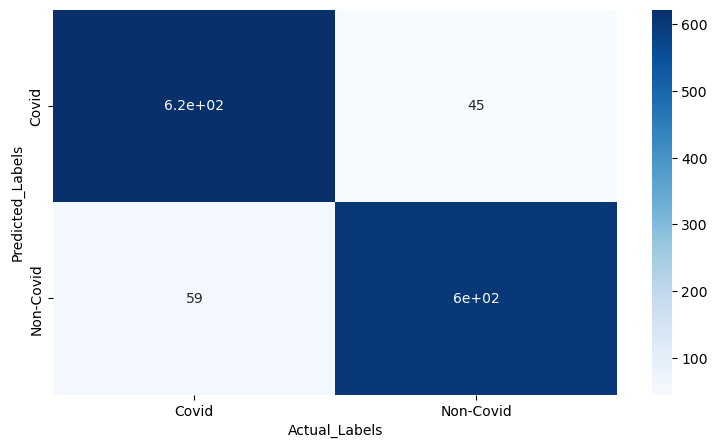

test accuracy = 92.16867469879519%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9217
Precision: 0.9219
Recall: 0.9217
F1 Score: 0.9217


In [ ]:
print('---------------------Student Model Evaluation on Dataset1, Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_balanced,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 0s 14ms/step


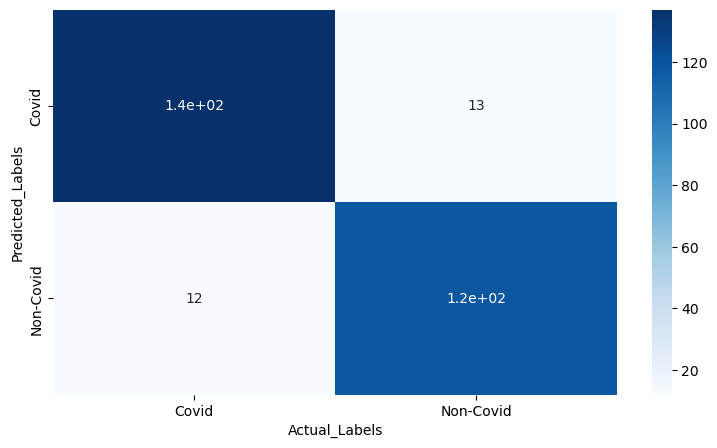

test accuracy = 91.07142857142857%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9107
Precision: 0.9107
Recall: 0.9107
F1 Score: 0.9107
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 0s 13ms/step


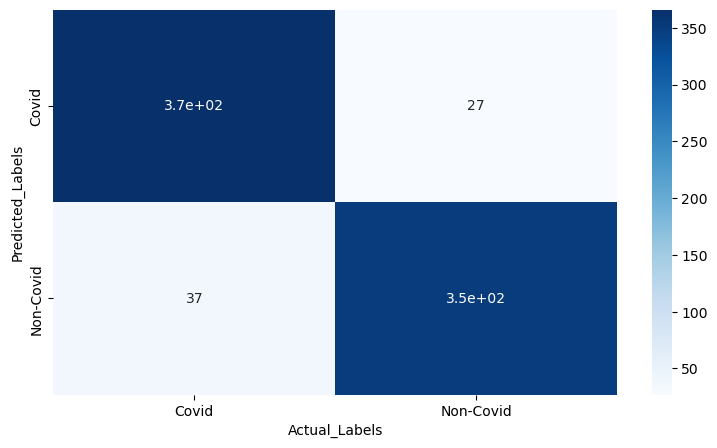

test accuracy = 91.7948717948718%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9179
Precision: 0.9183
Recall: 0.9179
F1 Score: 0.918
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 0s 12ms/step


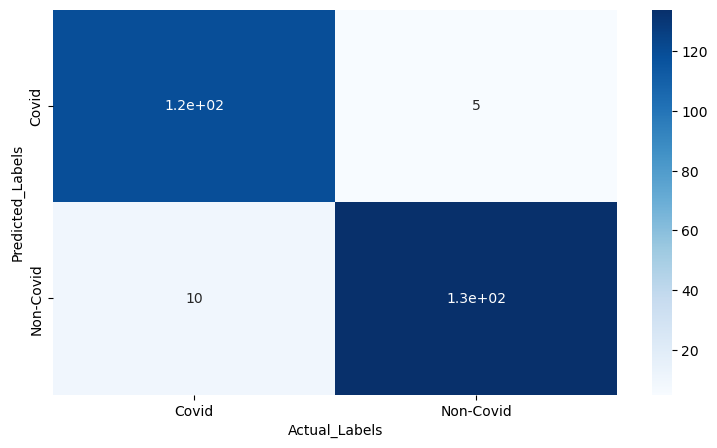

test accuracy = 94.40298507462687%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.944
Precision: 0.9446
Recall: 0.944
F1 Score: 0.944


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_balanced,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_balanced,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_MTKD_model_IID_balanced,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_MTKD_model_IID_balanced.save('gsm_iid_balanced.h5')

In [ ]:
metrics_nonIID_balanced['loss']
metrics_IID_unbalanced['loss']
metrics_IID_balanced['loss']
metrics_nonIID_balanced['Accuracy']
metrics_IID_unbalanced['Accuracy']
metrics_IID_balanced['Accuracy']

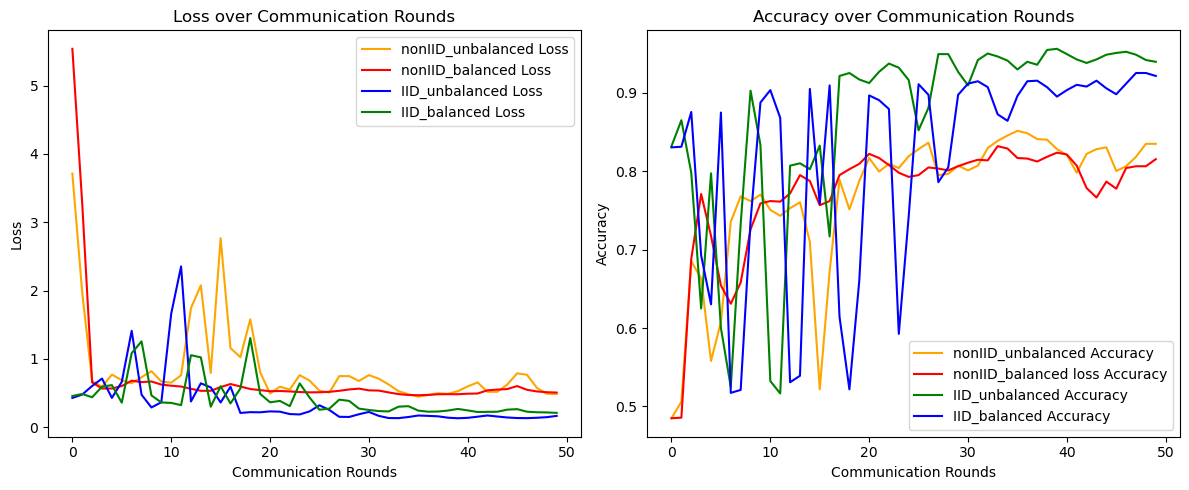

In [ ]:
import matplotlib.pyplot as plt


# Create a new figure
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(metrics_nonIID_unbalanced['loss'], label='nonIID_unbalanced Loss', color='orange')
plt.plot(metrics_nonIID_balanced['loss'], label='nonIID_balanced Loss',color='red')
plt.plot(metrics_IID_unbalanced['loss'], label='IID_unbalanced Loss',color='blue')
plt.plot(metrics_IID_balanced['loss'], label='IID_balanced Loss',color='green')

plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.title('Loss over Communication Rounds')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics_nonIID_unbalanced['accuracy'], label='nonIID_unbalanced Accuracy', color='orange')
plt.plot(metrics_nonIID_balanced['accuracy'] , label='nonIID_balanced loss Accuracy', color='red')
plt.plot(metrics_IID_unbalanced['accuracy'] , label='IID_unbalanced Accuracy', color='green')
plt.plot(metrics_IID_balanced['accuracy'], label='IID_balanced Accuracy', color='blue')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Communication Rounds')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:

import pickle
# # Dictionary to store all lists
# data = {
#     'metrics_nonIID_balanced_loss':metrics_nonIID_balanced['loss'],
#     'metrics_IID_unbalanced_loss': metrics_IID_unbalanced['loss'],
#     'metrics_IID_balanced_loss': metrics_IID_balanced['loss'],
#     'metrics_nonIID_balanced_accuracy': metrics_nonIID_balanced['accuracy'],
#     'metrics_IID_unbalanced_accuracy': metrics_IID_unbalanced['accuracy'],
#     'metrics_IID_balanced_accuracy': metrics_IID_balanced['accuracy']
# }

# # Save to a file
# with open('metrics_data.pkl', 'wb') as file:
#     pickle.dump(data, file)

# Load from a file
with open('metrics_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Accessing the lists
metrics_nonIID_balanced_loss = data['metrics_nonIID_balanced_loss']
metrics_IID_unbalanced_loss = data['metrics_IID_unbalanced_loss']
metrics_IID_balanced_loss = data['metrics_IID_balanced_loss']
metrics_nonIID_balanced_accuracy = data['metrics_nonIID_balanced_accuracy']
metrics_IID_unbalanced_accuracy = data['metrics_IID_unbalanced_accuracy']
metrics_IID_balanced_accuracy = data['metrics_IID_balanced_accuracy']